# Term Deposit Marketing 1
## Introduction
**Background:**  
- ACME is a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.
- We are interested in developing a robust machine learning system that leverages information coming from call center data.
- Ultimately, at ACME we are looking to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

**Data Description:**  
- The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**Attributes:**
- age: age of customer (numeric)
- job: type of job (categorical)
- marital: marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- Output (desired target):
    - y: has the client subscribed to a term deposit? (binary)

**Download Data:**
- https://drive.google.com/file/d/1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7

**Goal(s):**
- Predict if the customer will subscribe (yes/no) to a term deposit (variable y).

**Success Metric(s)**
- Hit 81% or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

**Bonus(es):**
- We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.
- What makes the customers buy? Tell us which feature we should be focusing more on.

### Libraries

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from operator import itemgetter
import missingno as msno

# Models imports
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lazypredict.Supervised import LazyClassifier

# Warnings imports
from warnings import filterwarnings
filterwarnings("ignore")

# Sklearn imports
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Other imports
import shap
from scipy.special import softmax
from itertools import permutations
import itertools

### Helper function(s)

In [2]:
# Prints a horizontal line for delineating outputs
def barrier():
    print("\n <<<", "-"*50, ">>> \n")

# Saves models
def save_model(model, name):
    with open("models/" + name + ".pkl", "wb") as f:
        pickle.dump(model, f)
    print(f"Model: {name}.pkl saved.")

# Loads models
def load_model(name):
    with open("models/" + name, "rb") as f:
        model = pickle.load(f)
    return model

# Saves models
def save_model_dropped(model, name):
    with open("models_dropped/" + name + ".pkl", "wb") as f:
        pickle.dump(model, f)
    print(f"Model: {name}.pkl saved.")

# Loads models
def load_model_dropped(name):
    with open("models_dropped/" + name, "rb") as f:
        model = pickle.load(f)
    return model

# Emboldening text
def print_bold(text):
    start = "\033[1m"
    end = "\033[0;0m"
    print(start + str(text) + end)

# Emboldening text
def bold(text):
    start = "\033[1m"
    end = "\033[0;0m"
    return start + str(text) + end

## Data

In [3]:
df = pd.read_csv("raw_data.csv")
display(df.head())
barrier()
display(df.tail())
barrier()
display(df.describe())
barrier()
display(df.info())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no



 <<< -------------------------------------------------- >>> 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no
39999,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no



 <<< -------------------------------------------------- >>> 



,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00



 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


None

### Uniqueness

In [4]:
# Print unique values in each column/feature
def print_uniques(df):
    for feature in df.columns:
        print(bold(feature), "------>", df[feature].unique())

print_uniques(df)

age ------> [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81]
job ------> ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ------> ['married' 'single' 'divorced']
education ------> ['tertiary' 'secondary' 'unknown' 'primary']
default ------> ['no' 'yes']
balance ------> [  2143     29      2 ...   7222   3402 102127]
housing ------> ['yes' 'no']
loan ------> ['no' 'yes']
contact ------> ['unknown' 'cellular' 'telephone']
day ------> [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month ------> ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
duration ------> [ 261  151   76 ... 1880 1460 2219]
campaign ------> [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 

### Data visualization

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [6]:
# Object dtypes
display(df.select_dtypes("object").columns)

# Int dtypes
display(df.select_dtypes("int").columns)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'y'],
      dtype='object')

Index(['age', 'balance', 'day', 'duration', 'campaign'], dtype='object')

#### Visualization functions

In [7]:
# Bar chart and pie chart for categorical features
def plot_feat_cat(df, col):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    df[col].value_counts().plot.bar(ax=ax1)
    df[col].value_counts().plot.pie(rotatelabels=True, ax=ax2, textprops={"fontsize":6})
    plt.tight_layout()
    plt.show()

# Histplot and distplot for numeric features
def plot_feat_num(df, col):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    df[col].hist(ax=ax1, xrot=-45)
    sns.distplot(df[col], ax=ax2)
    plt.xticks(rotation=-90)
    plt.tight_layout()
    plt.show()

### Numeric features

age :


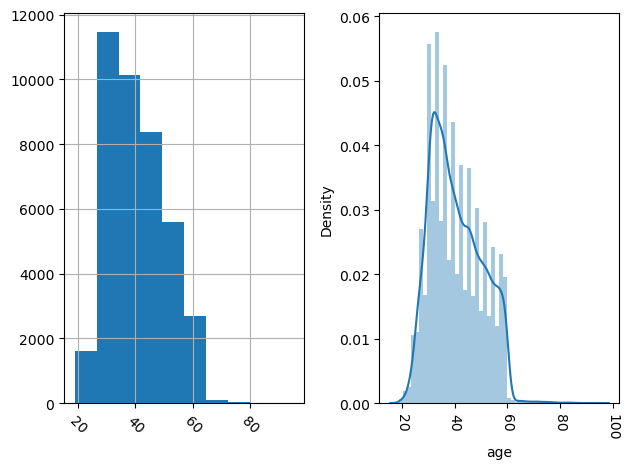


 <<< -------------------------------------------------- >>> 

balance :


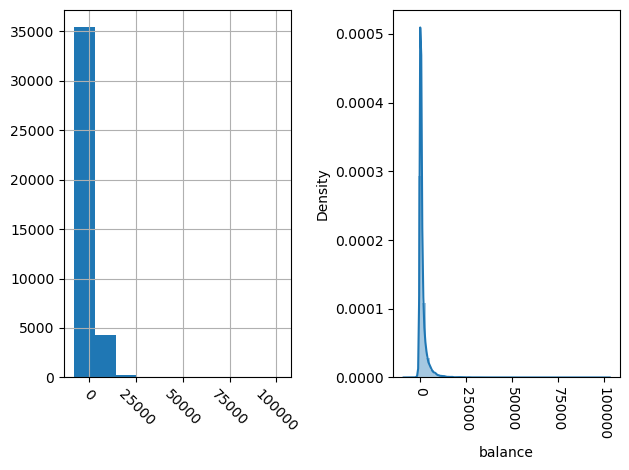


 <<< -------------------------------------------------- >>> 

day :


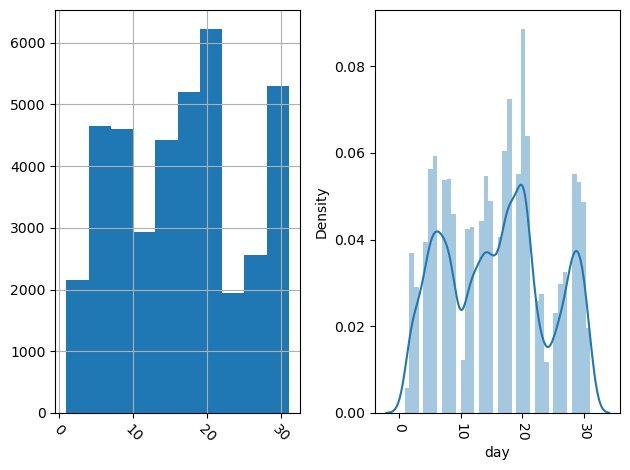


 <<< -------------------------------------------------- >>> 

duration :


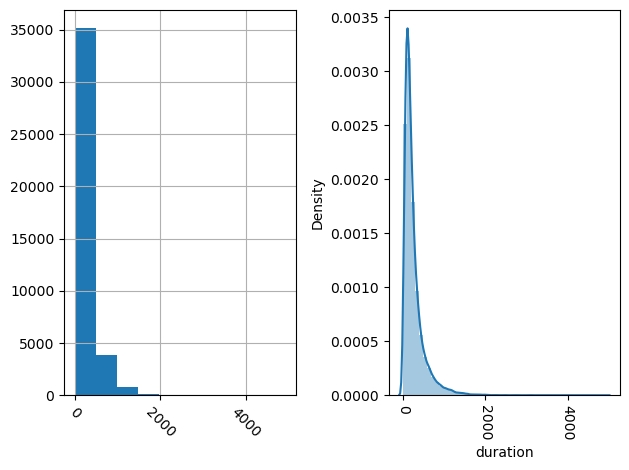


 <<< -------------------------------------------------- >>> 

campaign :


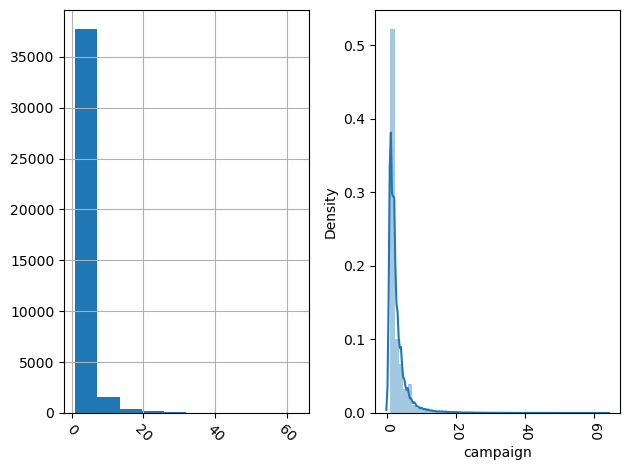


 <<< -------------------------------------------------- >>> 



In [8]:
# Histplot and distplot for numeric features
num_features = df.select_dtypes("int").columns

for feature in num_features:
    print(bold(feature), ":")
    plot_feat_num(df, feature)
    barrier()

#### Duration

In [9]:
df["duration"].describe()

count   40000.00
mean      254.82
std       259.37
min         0.00
25%       100.00
50%       175.00
75%       313.00
max      4918.00
Name: duration, dtype: float64

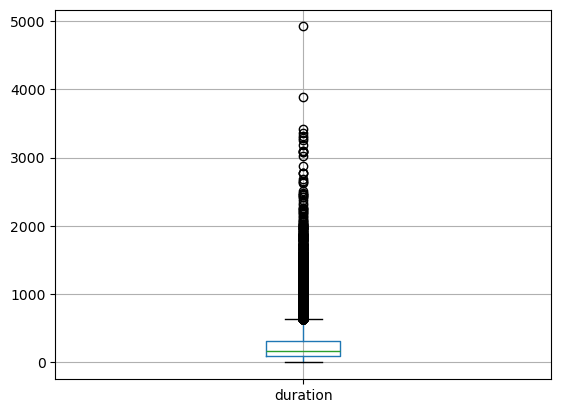

In [10]:
df[["duration"]].boxplot()
plt.show()

**NOTE:**
- A significant number of data points are greater than the 75th percentile of this feature.

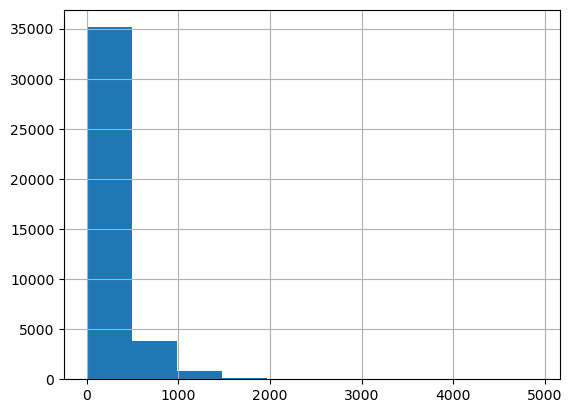

In [11]:
df["duration"].hist(bins=10)
plt.show()

#### Campaign

In [12]:
df["campaign"].describe()

count   40000.00
mean        2.88
std         3.24
min         1.00
25%         1.00
50%         2.00
75%         3.00
max        63.00
Name: campaign, dtype: float64

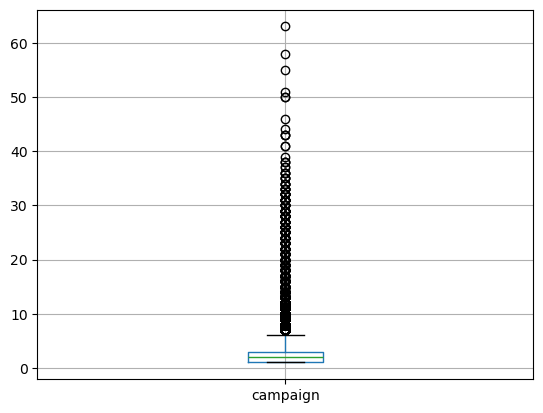

In [13]:
df[["campaign"]].boxplot()
plt.show()

**NOTE:**
- A significant number of data points are greater than the 75th percentile of this feature.

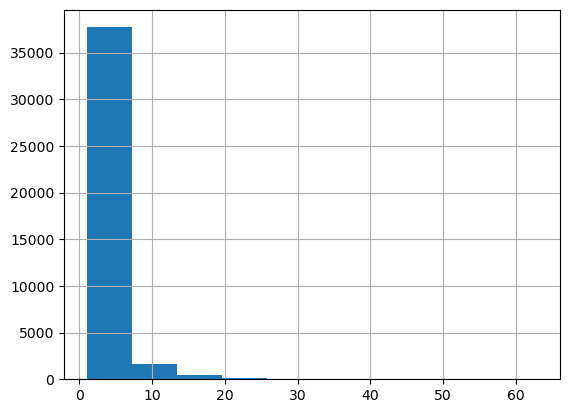

In [14]:
df["campaign"].hist(bins=10)
plt.show()

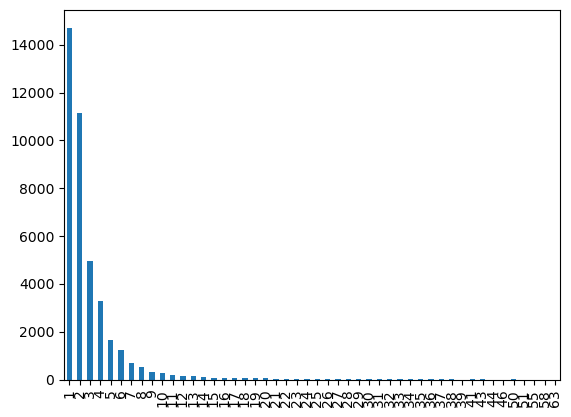

In [15]:
# Number of times individuals were contacted during campaign
df["campaign"].value_counts().sort_index().plot.bar()
plt.show()

#### Age

In [16]:
df["age"].describe()

count   40000.00
mean       40.54
std         9.64
min        19.00
25%        33.00
50%        39.00
75%        48.00
max        95.00
Name: age, dtype: float64

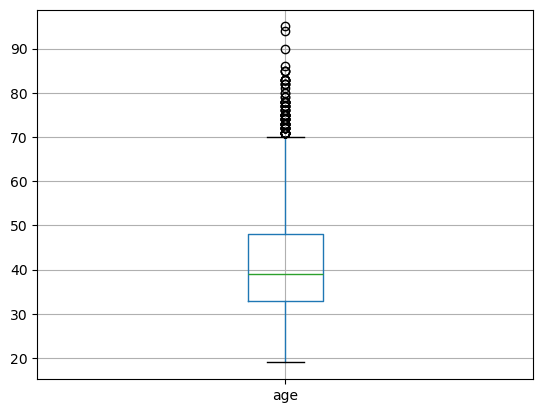

In [17]:
df[["age"]].boxplot()
plt.show()

**NOTE:**
- A significant number of data points are greater than the 75th percentile of this feature.

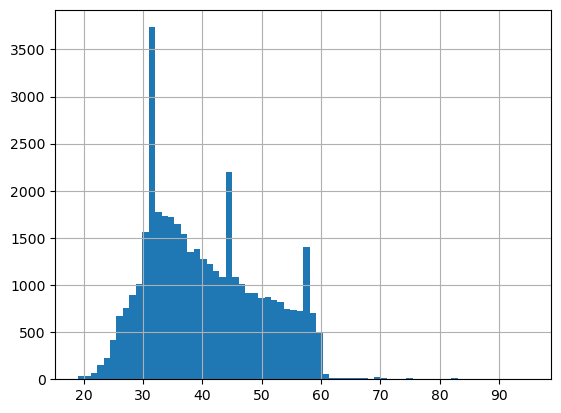

In [18]:
df["age"].hist(bins=len(df["age"].unique()))
plt.show()

#### Balance

In [19]:
df["balance"].describe()

count    40000.00
mean      1274.28
std       2903.77
min      -8019.00
25%         54.00
50%        407.00
75%       1319.00
max     102127.00
Name: balance, dtype: float64

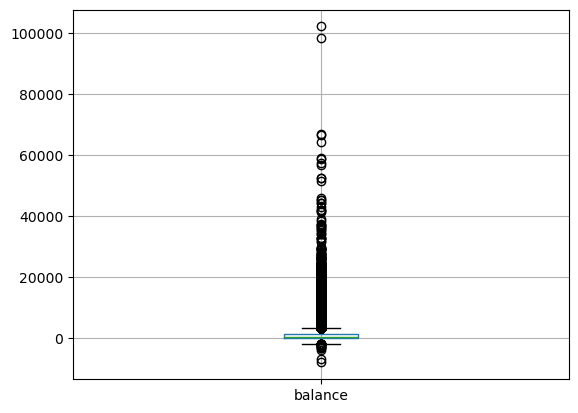

In [20]:
df[["balance"]].boxplot()
plt.show()

**NOTE:**
- A significant number of data points are both less than the 25th percentile and greater than the 75th percentile of this feature.

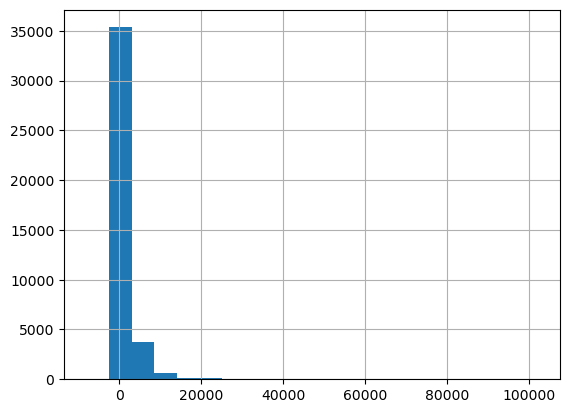

In [21]:
df["balance"].hist(bins=20)
plt.show()

### Categorical features

#### Day

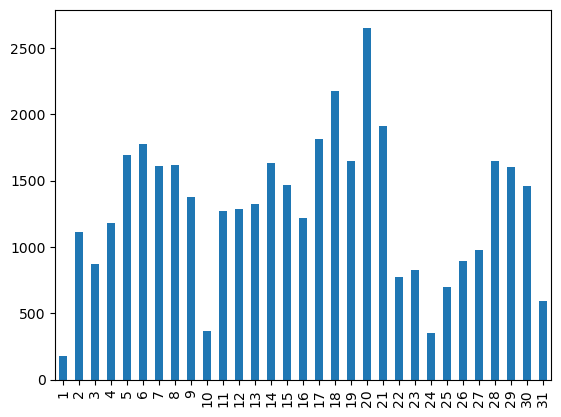

In [22]:
df["day"].value_counts().sort_index().plot.bar()
plt.show()

#### Month

In [23]:
df["month"].value_counts()

may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: month, dtype: int64

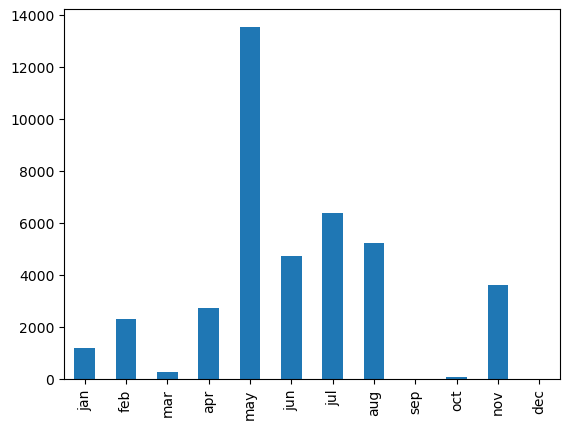

In [24]:
# Reindex months to chronological order
months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
df["month"].value_counts().reindex(months).plot.bar()
plt.show()

#### Y or Subscription

In [25]:
df.y.value_counts()

no     37104
yes     2896
Name: y, dtype: int64

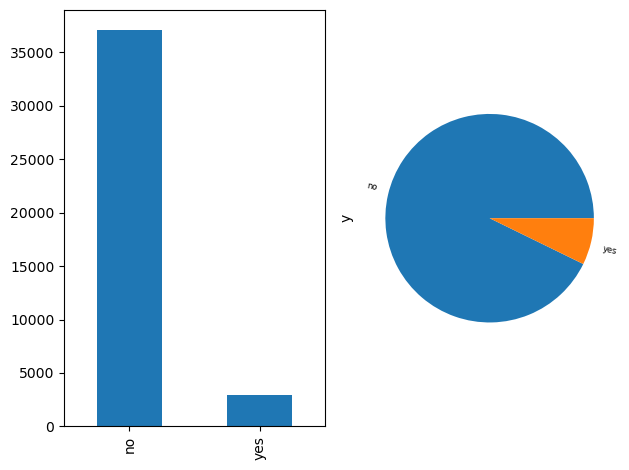

In [26]:
plot_feat_cat(df, "y")

#### Others

job :


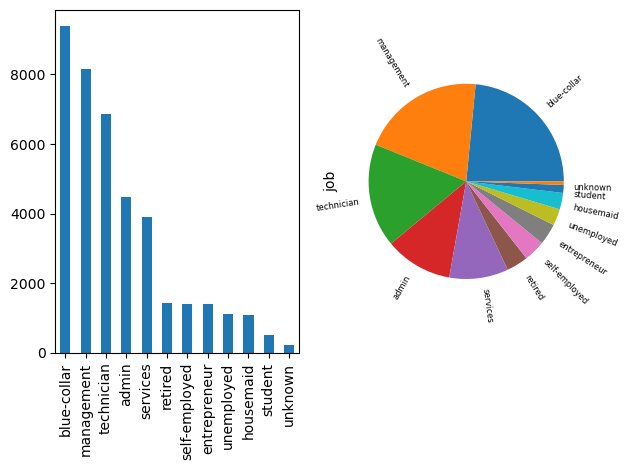


 <<< -------------------------------------------------- >>> 

marital :


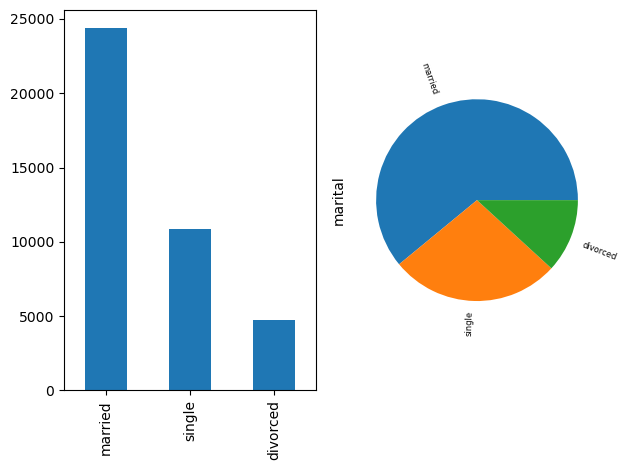


 <<< -------------------------------------------------- >>> 

education :


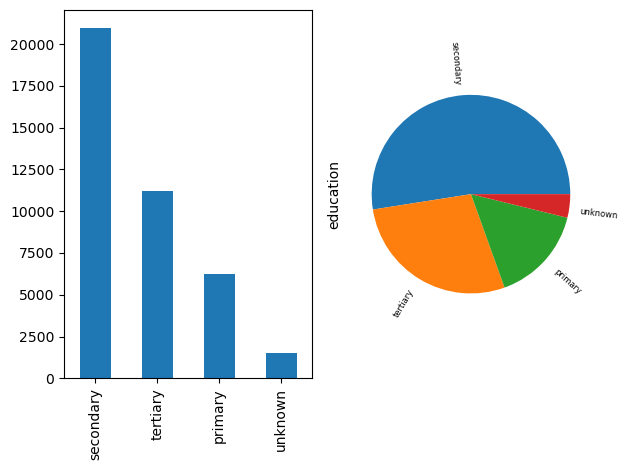


 <<< -------------------------------------------------- >>> 

default :


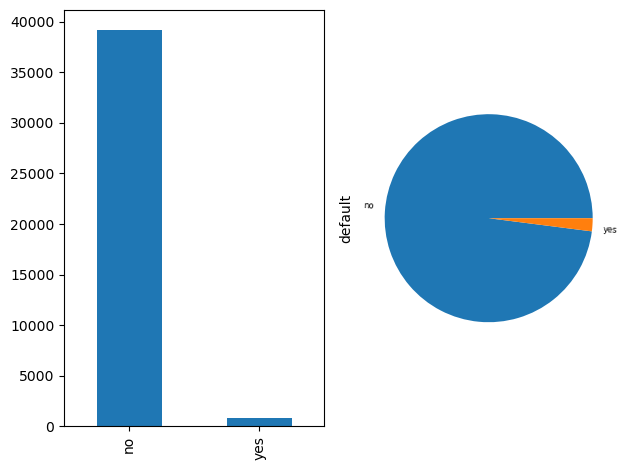


 <<< -------------------------------------------------- >>> 

housing :


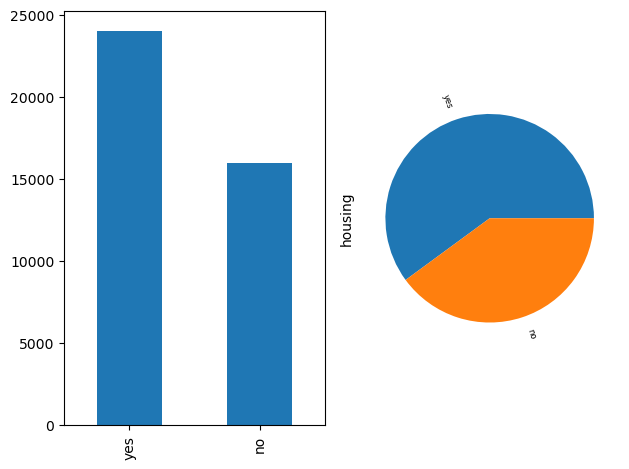


 <<< -------------------------------------------------- >>> 

loan :


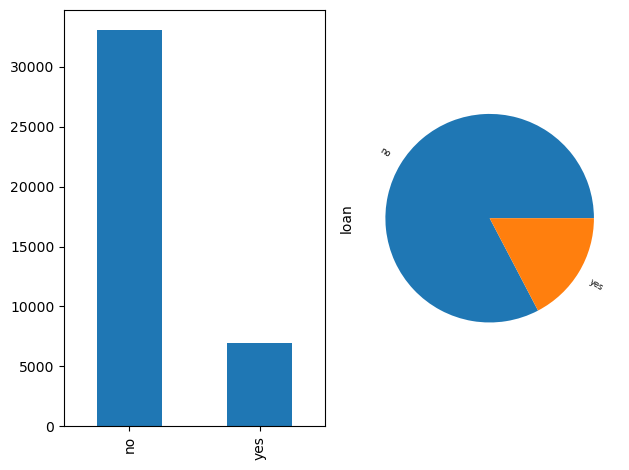


 <<< -------------------------------------------------- >>> 

contact :


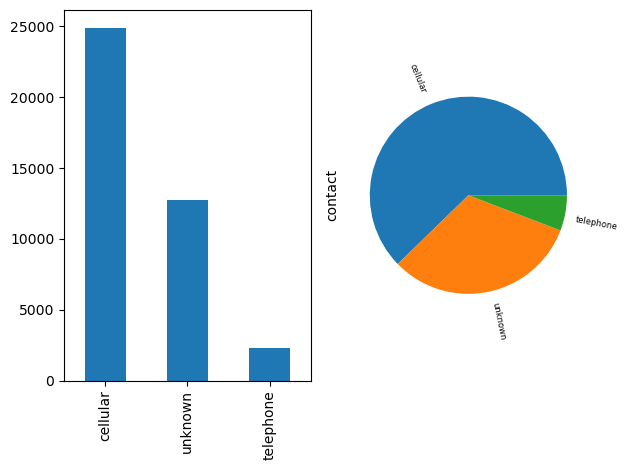


 <<< -------------------------------------------------- >>> 



In [27]:
# All categorical features except day, month or y
cat_features = [feature for feature in df.select_dtypes("object").columns if feature not in ["month", "y"]]

for feature in cat_features:
    print(bold(feature), ":")
    plot_feat_cat(df, feature)
    barrier()

## Preprocessing
### Null values

In [28]:
# Missing values
print(df.isnull().sum())
barrier()
print(df.isna().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

 <<< -------------------------------------------------- >>> 

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


**NOTE:**
- There are no missing values (null or nan) in our dataset.

In [29]:
# Print unique values in each column/feature
print_uniques(df)

age ------> [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81]
job ------> ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ------> ['married' 'single' 'divorced']
education ------> ['tertiary' 'secondary' 'unknown' 'primary']
default ------> ['no' 'yes']
balance ------> [  2143     29      2 ...   7222   3402 102127]
housing ------> ['yes' 'no']
loan ------> ['no' 'yes']
contact ------> ['unknown' 'cellular' 'telephone']
day ------> [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month ------> ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
duration ------> [ 261  151   76 ... 1880 1460 2219]
campaign ------> [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 

**NOTE:**
- There are "unknown" values in the **job**, **education** and **contact** non-integer features.
- These are effectively missing values that aren't marked null or nan.

In [30]:
# Replace unknown values with nan
df.replace("unknown", np.nan, inplace=True)

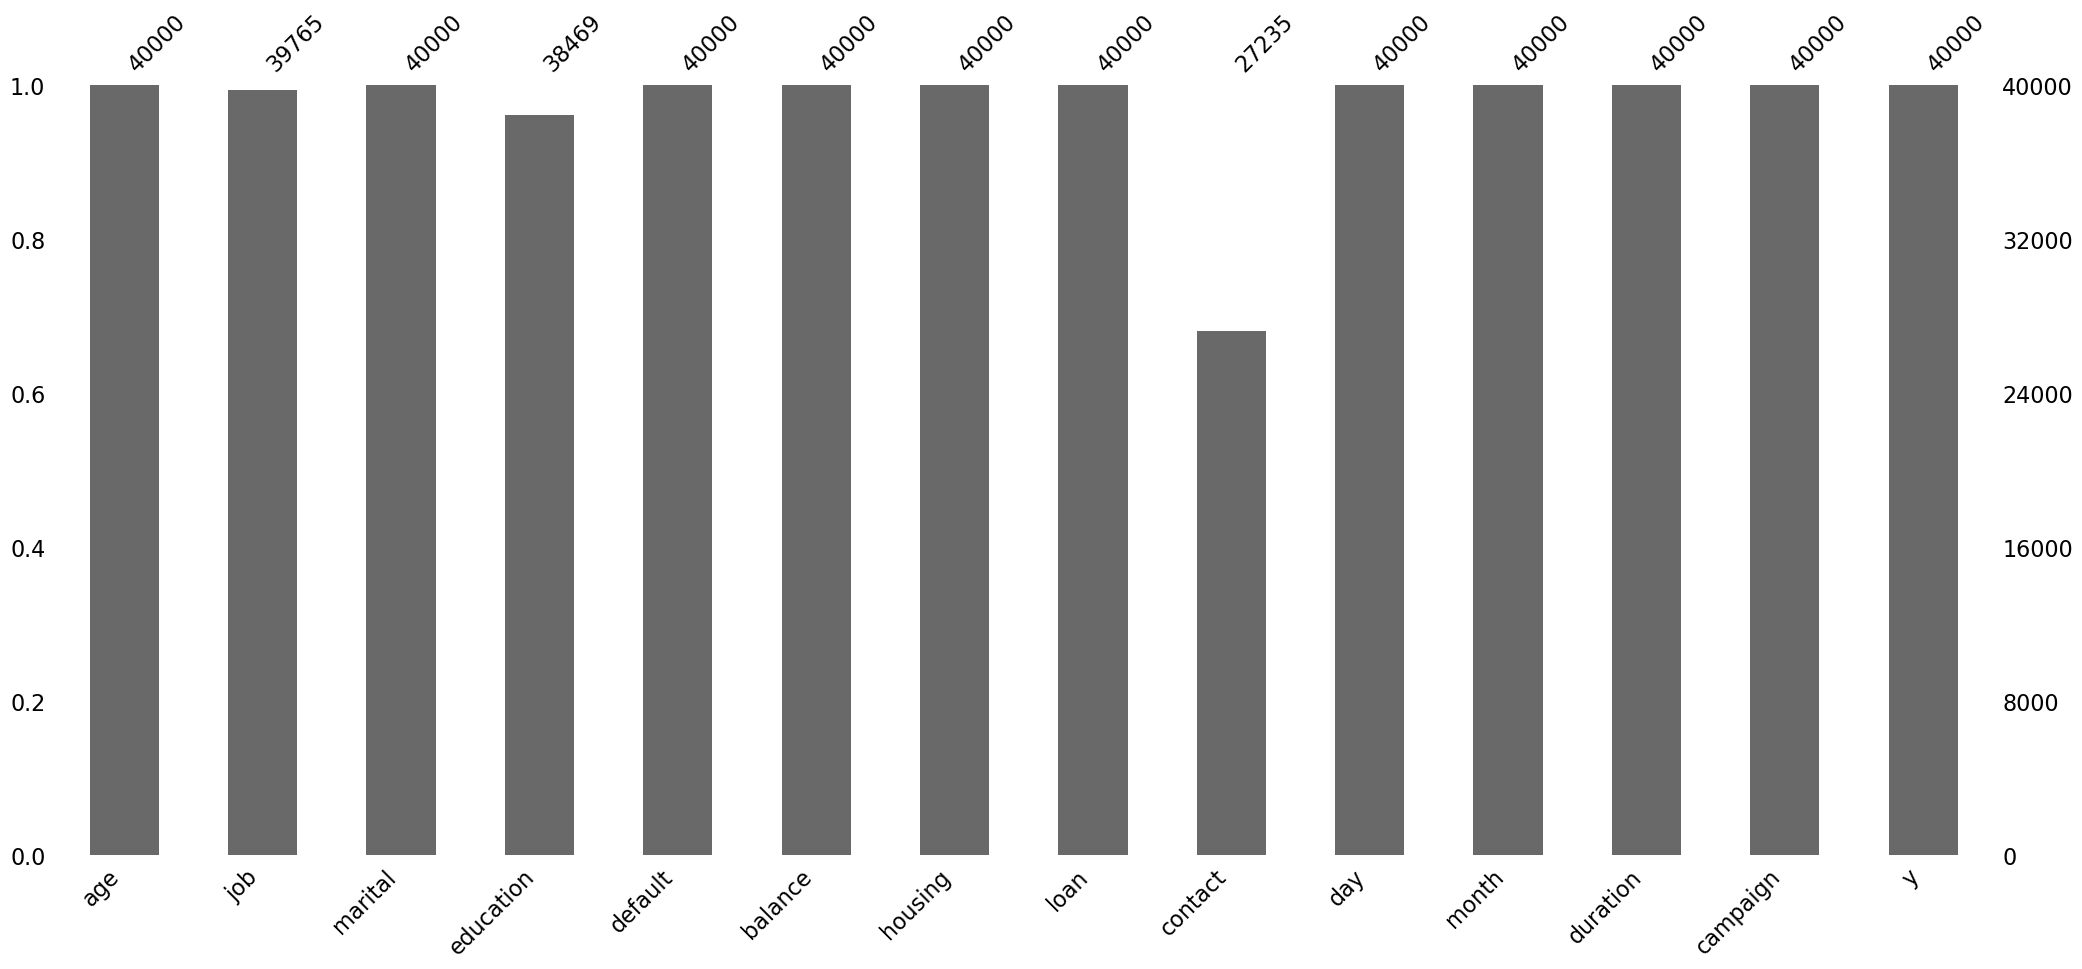

In [31]:
# Graphical depiction of missing values
msno.bar(df)
plt.show()

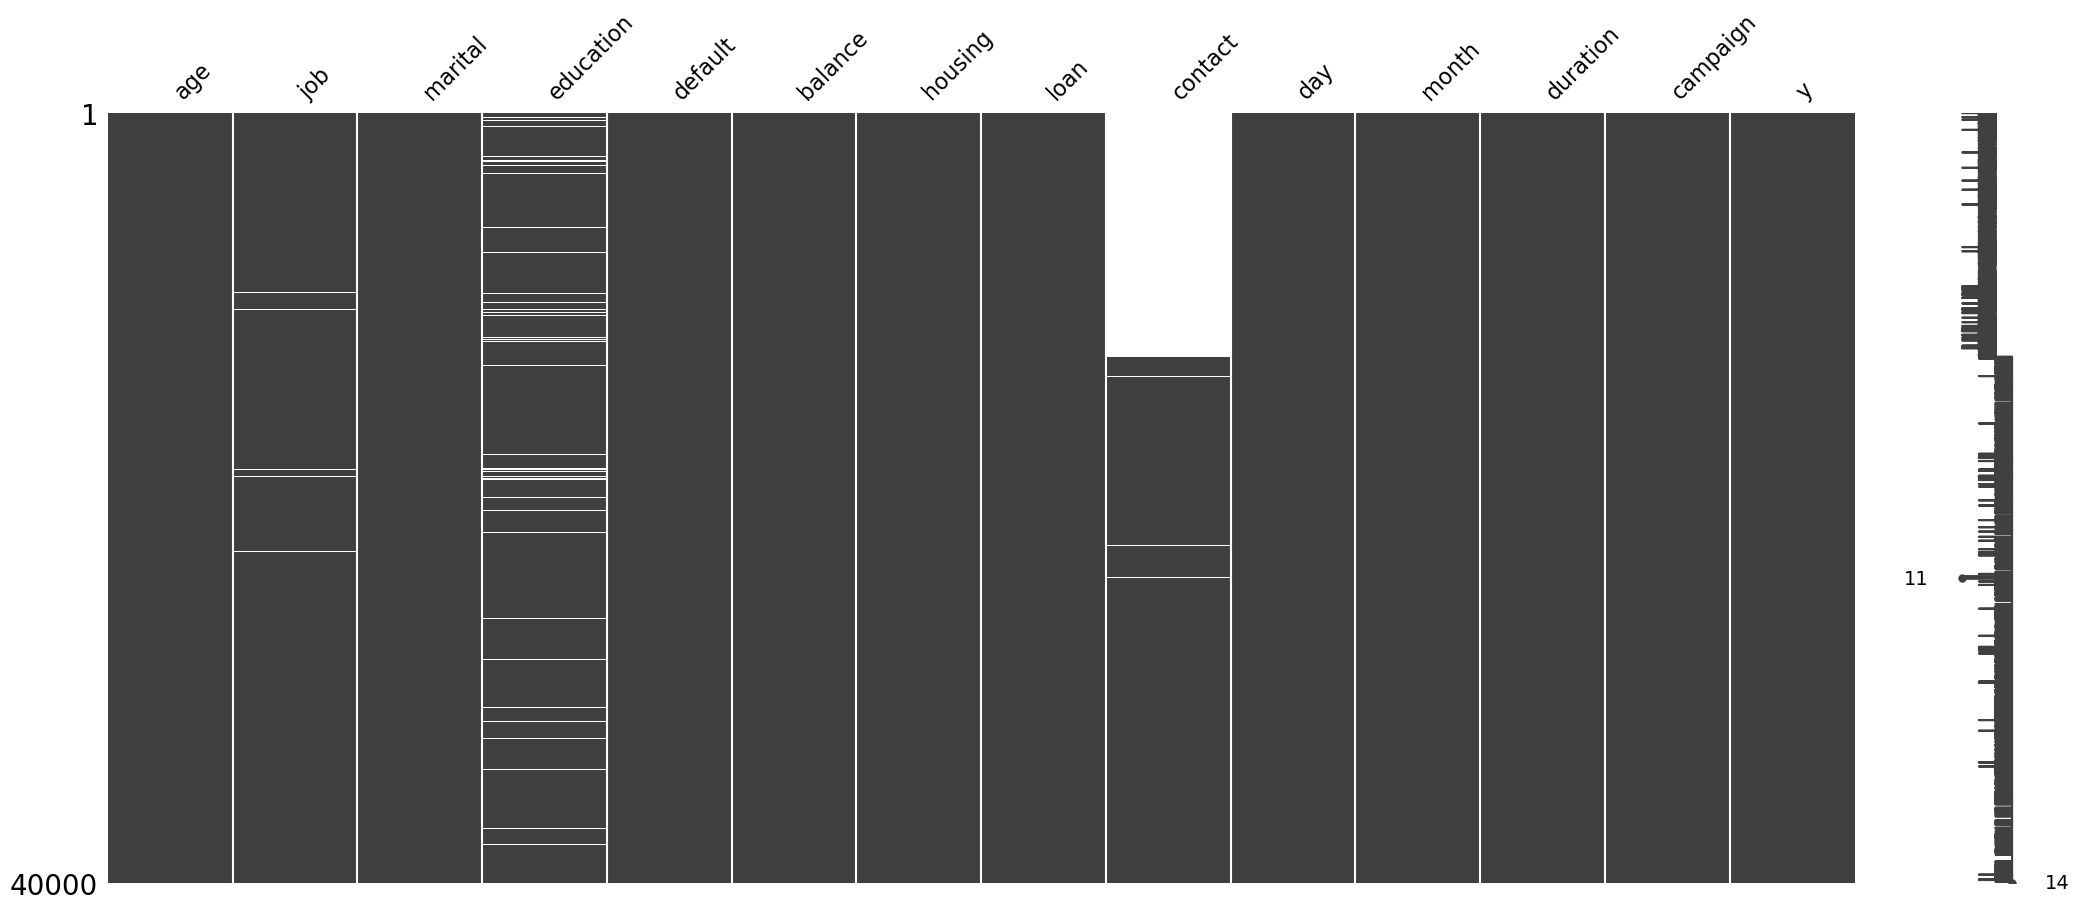

In [32]:
# Graphical depiction of missing values
msno.matrix(df)
plt.show()

#### Random imputation

In [33]:
# Replace nan with randomly sampled values from each features
def na_random_fill(series):
    na_mask = pd.isnull(series)
    n_null = na_mask.sum()
    if n_null == 0:
        return series
    fill_values = series[~na_mask].sample(n=n_null, replace=True, random_state=0)
    fill_values.index = series.index[na_mask]
    return series.fillna(fill_values)

df["job"] = na_random_fill(df["job"])
df["education"] = na_random_fill(df["education"])
df["contact"] = na_random_fill(df["contact"])

# Missing values check
print(df.isnull().sum())
barrier()
print(df.isna().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

 <<< -------------------------------------------------- >>> 

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


**NOTE:**
- Missing/null values have been removed from the dataset.

#### Label encoding

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [35]:
# Object dtypes
display(df.select_dtypes("object").columns)

# Int dtypes
display(df.select_dtypes("int").columns)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'y'],
      dtype='object')

Index(['age', 'balance', 'day', 'duration', 'campaign'], dtype='object')

In [36]:
# Label encoding for object dtypes
features = df.select_dtypes("object").columns
df_enc = df.copy()
df_enc[features]=df_enc[features].apply(lambda ser:pd.Series(LabelEncoder().fit_transform(ser),index=ser.index))

display(df.head())
barrier()
display(df_enc.head())
barrier()
display(df.info())
barrier()
display(df_enc.info())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,no
3,47,blue-collar,married,primary,no,1506,yes,no,cellular,5,may,92,1,no
4,33,admin,single,tertiary,no,1,no,no,cellular,5,may,198,1,no



 <<< -------------------------------------------------- >>> 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,0,5,8,261,1,0
1,44,9,2,1,0,29,1,0,0,5,8,151,1,0
2,33,2,1,1,0,2,1,1,0,5,8,76,1,0
3,47,1,1,0,0,1506,1,0,0,5,8,92,1,0
4,33,0,2,2,0,1,0,0,0,5,8,198,1,0



 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


None


 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        40000 non-null  int64
 1   job        40000 non-null  int32
 2   marital    40000 non-null  int32
 3   education  40000 non-null  int32
 4   default    40000 non-null  int32
 5   balance    40000 non-null  int64
 6   housing    40000 non-null  int32
 7   loan       40000 non-null  int32
 8   contact    40000 non-null  int32
 9   day        40000 non-null  int64
 10  month      40000 non-null  int32
 11  duration   40000 non-null  int64
 12  campaign   40000 non-null  int64
 13  y          40000 non-null  int32
dtypes: int32(9), int64(5)
memory usage: 2.9 MB


None

### Balancing the target feature

In [37]:
df.y.value_counts()

no     37104
yes     2896
Name: y, dtype: int64

**NOTE:**
- There are 37104 `no` values and only 2896 `yes` values.
- We will under-sample the data so as not to skew the prediction in favor of one potential outcome.
    - We will do this by creating a sub dataset with an equal number of "yes" and "no values.

In [38]:
ones = df_enc[df_enc["y"] == 1]
zeros = df_enc[df_enc["y"] == 0].sample(n=2896)

# Without random sampling
# df_enc_balanced = pd.concat([df_enc[df_enc["y"] == 0][0:2896], df_enc[df_enc["y"] == 1]])

# With random sampling
df_enc_balanced = pd.concat([ones, zeros]).reset_index(drop=True)

df_enc_balanced

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,59,0,1,1,0,2343,1,0,0,5,8,1042,1,1
1,56,0,1,1,0,45,0,0,0,5,8,1467,1,1
2,41,9,1,1,0,1270,1,0,0,5,8,1389,1,1
3,55,7,1,1,0,2476,1,0,0,5,8,579,1,1
4,54,0,1,2,0,184,0,0,0,5,8,673,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5787,32,9,1,1,0,-91,1,0,0,26,8,95,2,0
5788,48,4,0,2,0,15,0,0,0,6,9,88,1,0
5789,34,4,1,2,0,47,0,0,0,26,8,244,1,0
5790,28,1,2,1,0,5149,1,0,0,2,6,232,3,0


## Modeling full

#### Methodology

**NOTE:**
- Since we are targeting customers, we may make the intelligent assumption that KNN will be a good model since it is very good at classifying customer behaviors and customer demographics.
- Additionally, tree based models are very good when working with a combination of categorical/numeric data with minimal feature engineering.
- Similarly, boosting models are robust as they utilize an ensemble of multiple estimators as well as random feature sampling.
- This will be investigated in the sections below.

**NOTE:**
- Model hyperparameters are tuned for best performance and to mitigate overfitting. This is done using cross validation.
- Hyperparameter tuning is expensive; both computationally and timewise.

#### One hot encoding

In [39]:
df_enc_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5792 entries, 0 to 5791
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        5792 non-null   int64
 1   job        5792 non-null   int32
 2   marital    5792 non-null   int32
 3   education  5792 non-null   int32
 4   default    5792 non-null   int32
 5   balance    5792 non-null   int64
 6   housing    5792 non-null   int32
 7   loan       5792 non-null   int32
 8   contact    5792 non-null   int32
 9   day        5792 non-null   int64
 10  month      5792 non-null   int32
 11  duration   5792 non-null   int64
 12  campaign   5792 non-null   int64
 13  y          5792 non-null   int32
dtypes: int32(9), int64(5)
memory usage: 430.0 KB


In [40]:
print_uniques(df_enc_balanced)

age ------> [59 56 41 55 54 42 60 39 37 34 28 30 36 45 53 38 29 46 31 35 32 49 43 26
 40 33 24 23 48 52 57 51 44 50 27 47 25 58 61 62 68 75 22 69 64 66 85 72
 90 67 71 21 63 73 74 65 83 79 70 76 77 19 20 78 95]
job ------> [ 0  9  7  4  5 10  1  2  3  6  8]
marital ------> [1 2 0]
education ------> [1 2 0]
default ------> [0 1]
balance ------> [2343   45 1270 ...  537  -91 5149]
housing ------> [1 0]
loan ------> [0 1]
contact ------> [0 1]
day ------> [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31]
month ------> [ 8  6  5  1 10  9  2  4  3  7  0]
duration ------> [1042 1467 1389 ... 1026  977 1529]
campaign ------> [ 1  2  3  4  5  6 32  8 11  7  9 10 15 12 14 17 13 24 29 16 21 20 55 33
 27 18 36 19 25 22 51 35 28 26 30]
y ------> [1 0]


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [42]:
# One-hot encoding the categorical variables with more than 1 category
df_enc_oh = pd.get_dummies(df_enc_balanced, columns=["job", "marital", "education", "month"], drop_first=True)
df_enc_oh.head()

,age,default,balance,housing,loan,contact,day,duration,campaign,y,...,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10
0,59,0,2343,1,0,0,5,1042,1,1,...,0,0,0,0,0,0,0,1,0,0
1,56,0,45,0,0,0,5,1467,1,1,...,0,0,0,0,0,0,0,1,0,0
2,41,0,1270,1,0,0,5,1389,1,1,...,0,0,0,0,0,0,0,1,0,0
3,55,0,2476,1,0,0,5,579,1,1,...,0,0,0,0,0,0,0,1,0,0
4,54,0,184,0,0,0,5,673,2,1,...,0,0,0,0,0,0,0,1,0,0


In [43]:
df_enc_oh.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'contact', 'day',
       'duration', 'campaign', 'y', 'job_1', 'job_2', 'job_3', 'job_4',
       'job_5', 'job_6', 'job_7', 'job_8', 'job_9', 'job_10', 'marital_1',
       'marital_2', 'education_1', 'education_2', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10'],
      dtype='object')

**NOTE:**
- We dropped the first columns to prevent issues with multi-collinearity.

#### Train and test split

In [44]:
RANDOM_STATE = 42
X = df_enc_oh.drop("y", axis=1)
y = df_enc_oh["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
print_bold("X_train.shape, y_train.shape, X_test.shape, y_test.shape:")
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print_bold("y_train.sum(), y_test.sum(), y.sum():")
display(y_train.sum(), y_test.sum(), y.sum())

X_train.shape, y_train.shape, X_test.shape, y_test.shape:


(4054, 33)

(4054,)

(1738, 33)

(1738,)

y_train.sum(), y_test.sum(), y.sum():


2005

891

2896

#### Lazypredict

In [45]:
# Lazy preliminary assessment of multiple models
clf = LazyClassifier(verbose=-1, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:08<00:00,  3.54it/s]

[LightGBM] [Info] Number of positive: 2005, number of negative: 2049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 4054, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494573 -> initscore=-0.021708
[LightGBM] [Info] Start training from score -0.021708
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.88               0.88     0.88      0.88   
RandomForestClassifier             0.88               0.88     0.88      0.88   
XGBClassifier                      0.87               0.87     0.87      0.87   
SVC                                0.86  

**NOTE:**
- Lazypredict provides an initial estimation of how different models may perform with the data.
- However, this assessment should be considered a rough guideline as it is made without model tuning.
- Thus, it will only serve informational purposes going forward.

#### Model evaluation functions

In [46]:
# Functions to evaluate models
# Draw roc-auc curve
def draw_roc(model):
    roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - AUC (area={roc_auc})")
    plt.show()

# Fit and evaluate model
def evaluate(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cross_val = cross_val_score(model, X_test, y_test, cv=5).mean()
    print_bold(f"Training accuracy: {model.score(X_train, y_train)}")
    print_bold(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
    print_bold(f"5-Fold Cross Validation Accuracy: {cross_val}")
    barrier()
    print_bold("Classification report:")
    print(classification_report(y_test, y_pred))
    cross = cross_val_score(model, X_test, y_test, cv=5).mean()
    barrier()
    draw_roc(model)
    barrier()
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate models without re-fitting
def evaluate_no_fit(model):
    y_pred = model.predict(X_test)
    cross_val = cross_val_score(model, X_test, y_test, cv=5).mean()
    print_bold(f"Training accuracy: {model.score(X_train, y_train)}")
    print_bold(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
    print_bold(f"5-Fold Cross Validation Accuracy: {cross_val}")
    barrier()
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    cross = cross_val_score(model, X_test, y_test, cv=5).mean()
    barrier()
    draw_roc(model)
    barrier()
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Confusion Matrix")
    plt.show()

# Assess and plot the standard devs of the cv scores for each fold and parameter set
def cv_std(cv):
    y = cv.cv_results_["std_test_score"]
    x = np.arange(1, y.shape[0] + 1)
    print(f"Mean of the standard deviations: {y.mean()}")
    print(f"Std of the standard deviations: {y.std()}")
    barrier()
    plt.plot(x, y)
    plt.title("Standard devs of CV scores")
    plt.xlabel("Param Candidates")
    plt.ylabel("Stds")
    plt.show()

### Logistic regression

Training accuracy: 0.8110508140108534
Test accuracy: 0.8141542002301496
5-Fold Cross Validation Accuracy: 0.8153052436317865

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       847
           1       0.85      0.78      0.81       891

    accuracy                           0.81      1738
   macro avg       0.82      0.82      0.81      1738
weighted avg       0.82      0.81      0.81      1738


 <<< -------------------------------------------------- >>> 



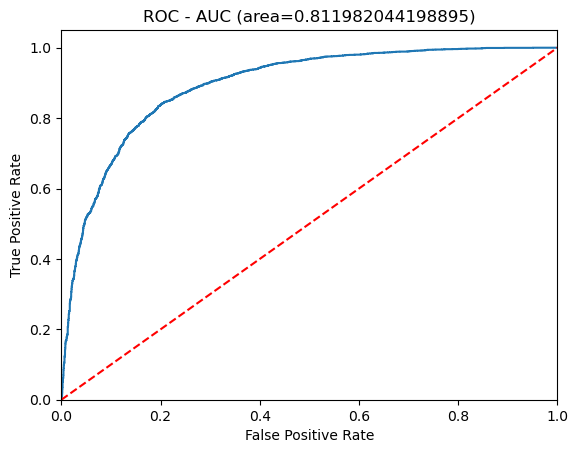


 <<< -------------------------------------------------- >>> 



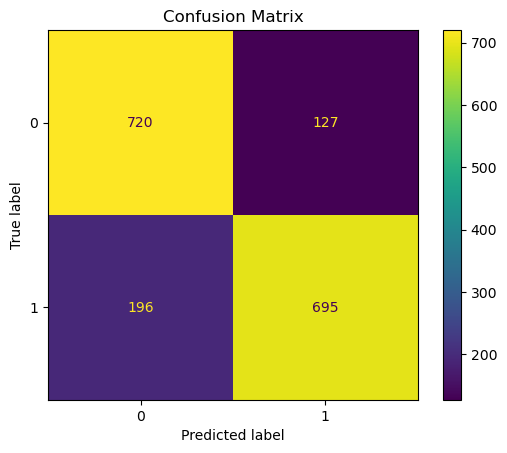

In [47]:
LR = LogisticRegression()
evaluate(LR)

In [48]:
# Save model
save_model(LR, "LR")

Model: LR.pkl saved.


### Gaussian naive bayes

Training accuracy: 0.7471632955106068
Test accuracy: 0.7399309551208285
5-Fold Cross Validation Accuracy: 0.7681142137864785

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.86      0.76       847
           1       0.83      0.62      0.71       891

    accuracy                           0.74      1738
   macro avg       0.76      0.74      0.74      1738
weighted avg       0.76      0.74      0.74      1738


 <<< -------------------------------------------------- >>> 



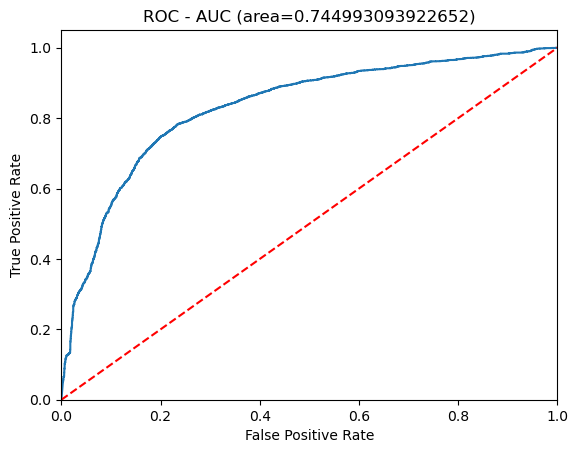


 <<< -------------------------------------------------- >>> 



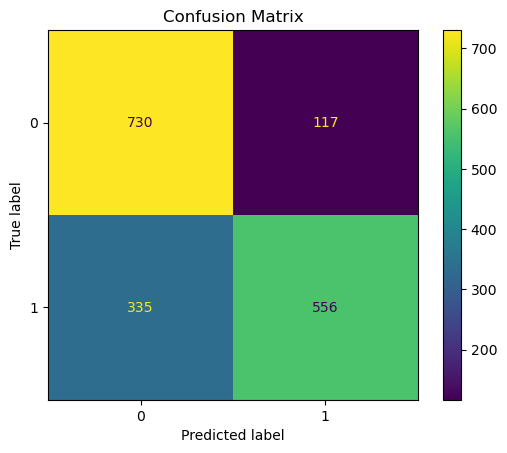

In [49]:
GNB = GaussianNB()
evaluate(GNB)

In [50]:
# Save model
save_model(GNB, "GNB")

Model: GNB.pkl saved.


### K nearest neighbours

Training accuracy: 0.8302910705476073
Test accuracy: 0.7669735327963176
5-Fold Cross Validation Accuracy: 0.7646841564808374

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       847
           1       0.79      0.74      0.77       891

    accuracy                           0.77      1738
   macro avg       0.77      0.77      0.77      1738
weighted avg       0.77      0.77      0.77      1738


 <<< -------------------------------------------------- >>> 



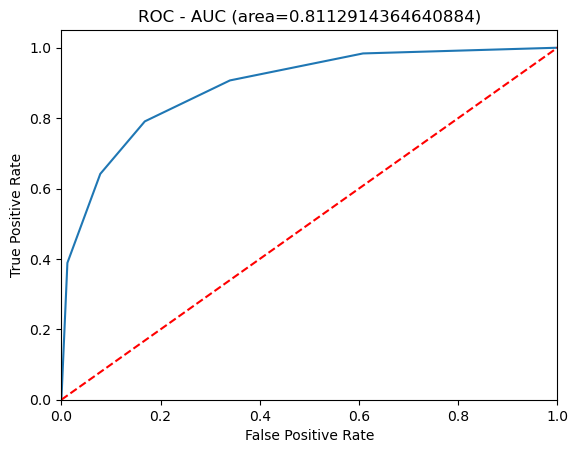


 <<< -------------------------------------------------- >>> 



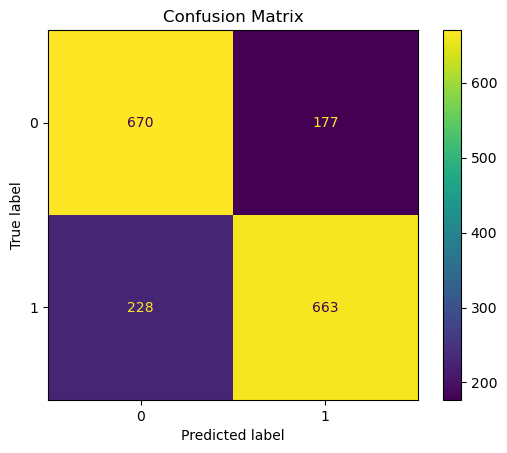

In [51]:
KNN = KNeighborsClassifier()
evaluate(KNN)

Fitting 5 folds for each of 14 candidates, totalling 70 fits

 <<< -------------------------------------------------- >>> 

Tuned model paramaters: {'n_neighbors': 14}
Tuned model best score: 0.7814440334292369
Training accuracy: 0.8011840157868771
Test accuracy: 0.7922899884925202
5-Fold Cross Validation Accuracy: 0.7692785451654577

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       847
           1       0.84      0.74      0.78       891

    accuracy                           0.79      1738
   macro avg       0.80      0.79      0.79      1738
weighted avg       0.80      0.79      0.79      1738


 <<< -------------------------------------------------- >>> 



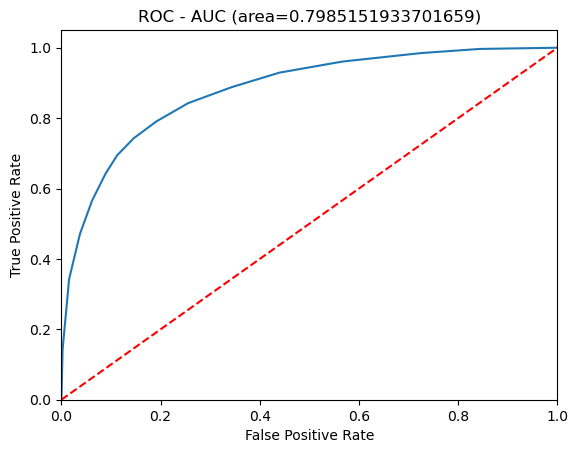


 <<< -------------------------------------------------- >>> 



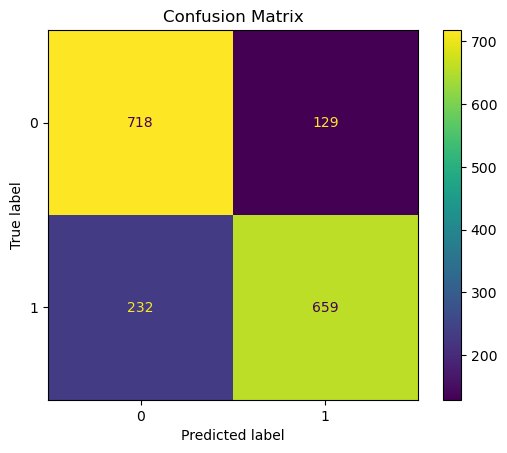

In [52]:
KNN = KNeighborsClassifier()

param_grid = {"n_neighbors": np.arange(1, 15)}

model_cv = GridSearchCV(KNN, param_grid, cv=5, n_jobs=-1, verbose=1)
model_cv.fit(X_train, y_train)
barrier()
print(f"Tuned model paramaters: {model_cv.best_params_}")
print(f"Tuned model best score: {model_cv.best_score_}")
evaluate_no_fit(model_cv.best_estimator_)

Training accuracy: 0.8011840157868771
Test accuracy: 0.7922899884925202
5-Fold Cross Validation Accuracy: 0.7692785451654577

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       847
           1       0.84      0.74      0.78       891

    accuracy                           0.79      1738
   macro avg       0.80      0.79      0.79      1738
weighted avg       0.80      0.79      0.79      1738


 <<< -------------------------------------------------- >>> 



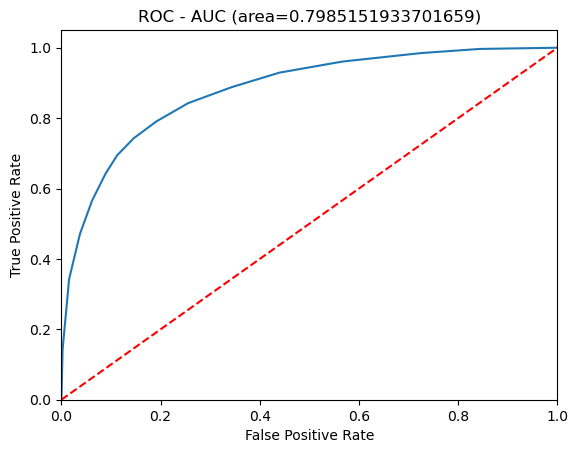


 <<< -------------------------------------------------- >>> 



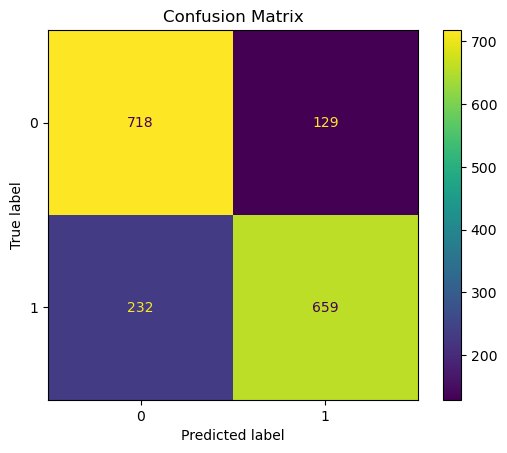

In [53]:
KNN = KNeighborsClassifier().set_params(**model_cv.best_params_)
evaluate(KNN)

### Decision tree

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 <<< -------------------------------------------------- >>> 

Tuned model paramaters: {'max_depth': 7, 'min_samples_split': 49}
Tuned model best score: 0.8367048758581845
Training accuracy: 0.8635915145535273
Test accuracy: 0.8354430379746836
5-Fold Cross Validation Accuracy: 0.8152953062373711

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       847
           1       0.83      0.85      0.84       891

    accuracy                           0.84      1738
   macro avg       0.84      0.84      0.84      1738
weighted avg       0.84      0.84      0.84      1738


 <<< -------------------------------------------------- >>> 



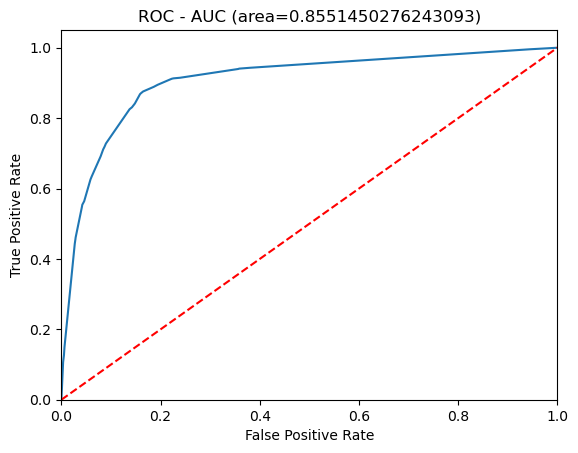


 <<< -------------------------------------------------- >>> 



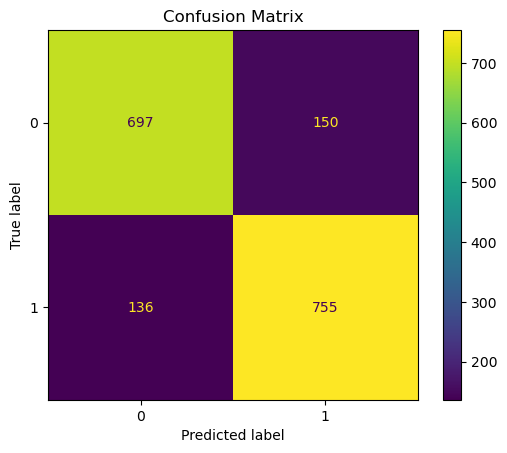

In [54]:
DTC = DecisionTreeClassifier()

param_grid = {"max_depth": range(1, 10), "min_samples_split": list(range(2, 50))}

model_cv = GridSearchCV(DTC, param_grid, cv=5, n_jobs=-1, verbose=1)
model_cv.fit(X_train, y_train)
barrier()
print(f"Tuned model paramaters: {model_cv.best_params_}")
print(f"Tuned model best score: {model_cv.best_score_}")
evaluate_no_fit(model_cv.best_estimator_)

Training accuracy: 0.8635915145535273
Test accuracy: 0.8354430379746836
5-Fold Cross Validation Accuracy: 0.8152953062373711

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       847
           1       0.83      0.85      0.84       891

    accuracy                           0.84      1738
   macro avg       0.84      0.84      0.84      1738
weighted avg       0.84      0.84      0.84      1738


 <<< -------------------------------------------------- >>> 



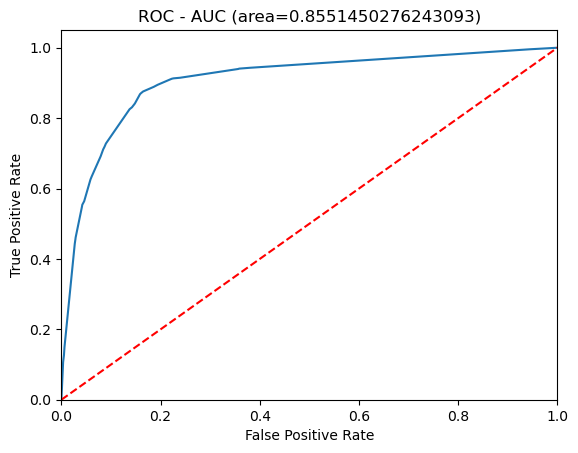


 <<< -------------------------------------------------- >>> 



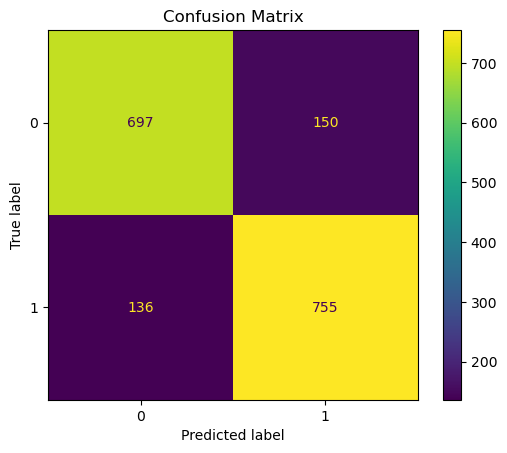

In [55]:
DTC = DecisionTreeClassifier().set_params(**model_cv.best_params_)
evaluate(DTC)

In [56]:
# Save model
save_model(DTC, "DTC")

Model: DTC.pkl saved.


### Random forest

Fitting 5 folds for each of 81 candidates, totalling 405 fits

 <<< -------------------------------------------------- >>> 

Tuned model paramaters: {'max_depth': 8, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 100}
Tuned model best score: 0.8544613417363109
Training accuracy: 0.8843117908238777
Test accuracy: 0.8659378596087457
5-Fold Cross Validation Accuracy: 0.853847427871079

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       847
           1       0.87      0.87      0.87       891

    accuracy                           0.87      1738
   macro avg       0.87      0.87      0.87      1738
weighted avg       0.87      0.87      0.87      1738


 <<< -------------------------------------------------- >>> 



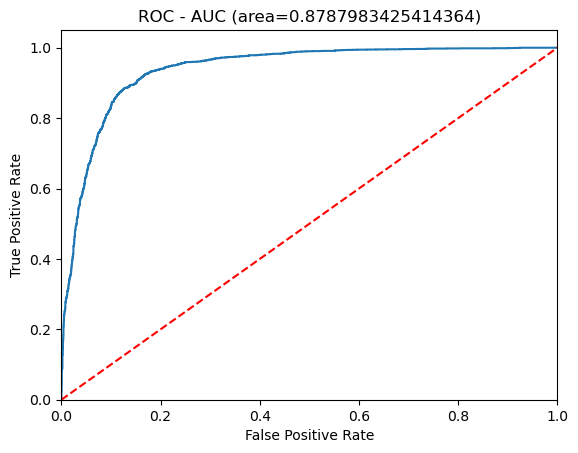


 <<< -------------------------------------------------- >>> 



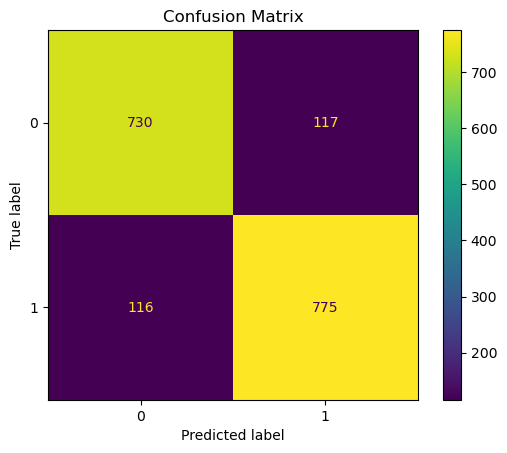

In [57]:
RF = RandomForestClassifier()

param_grid = {"max_depth":[2,5,8], "max_features":[2,5,8], "n_estimators":[10,50,100], "min_samples_split":[2,5,10]}

model_cv = GridSearchCV(RF, param_grid, cv=5, n_jobs=-1, verbose=1)
model_cv.fit(X_train, y_train)
barrier()
print(f"Tuned model paramaters: {model_cv.best_params_}")
print(f"Tuned model best score: {model_cv.best_score_}")
evaluate_no_fit(model_cv.best_estimator_)

Training accuracy: 0.8793783917118895
Test accuracy: 0.8642117376294591
5-Fold Cross Validation Accuracy: 0.8498161582033191

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       847
           1       0.87      0.86      0.87       891

    accuracy                           0.86      1738
   macro avg       0.86      0.86      0.86      1738
weighted avg       0.86      0.86      0.86      1738


 <<< -------------------------------------------------- >>> 



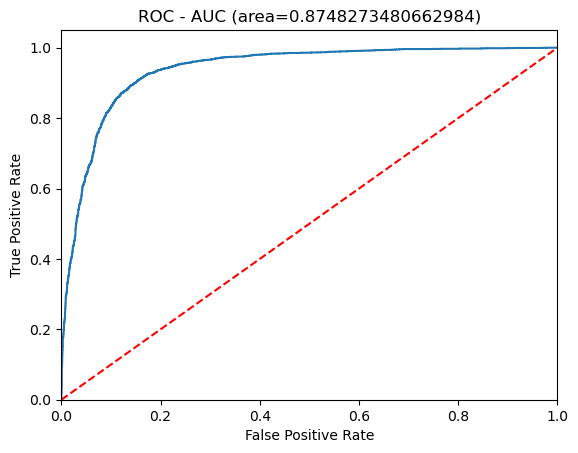


 <<< -------------------------------------------------- >>> 



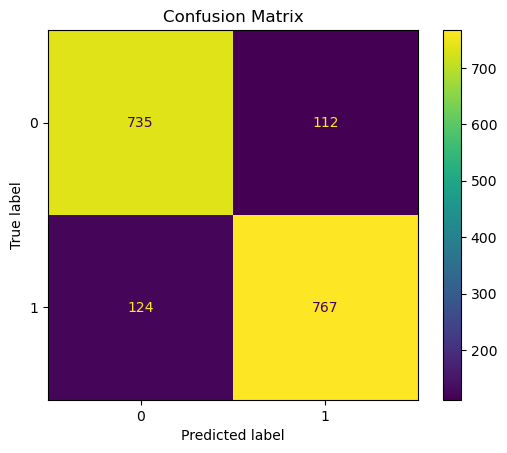

In [58]:
RF = RandomForestClassifier().set_params(**model_cv.best_params_)
evaluate(RF)

In [59]:
# Save model
save_model(RF, "RF")

Model: RF.pkl saved.


### XGBoost

Training accuracy: 0.8734583127775037
Test accuracy: 0.8584579976985041
5-Fold Cross Validation Accuracy: 0.8429063566199609

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       847
           1       0.86      0.86      0.86       891

    accuracy                           0.86      1738
   macro avg       0.86      0.86      0.86      1738
weighted avg       0.86      0.86      0.86      1738


 <<< -------------------------------------------------- >>> 



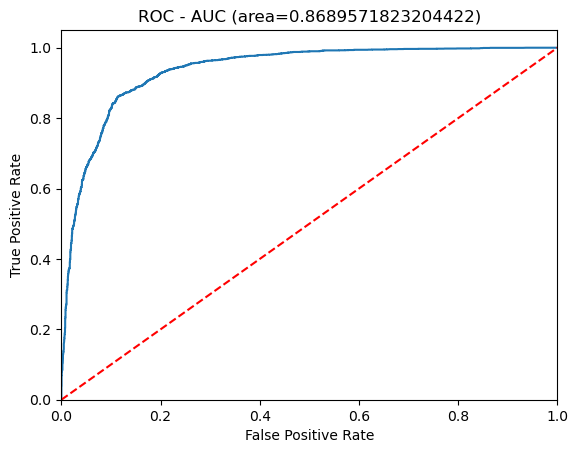


 <<< -------------------------------------------------- >>> 



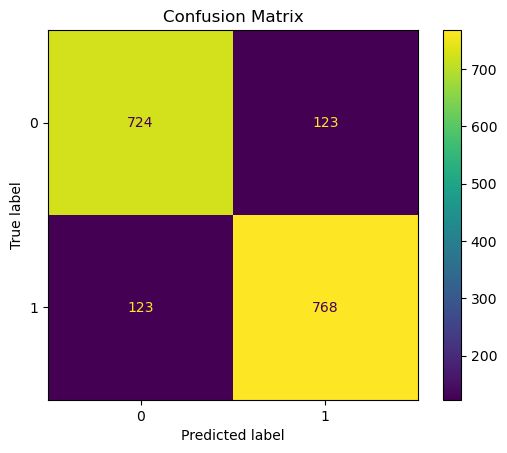

In [60]:
XGB = XGBClassifier(learning_rate=0.01, max_depth=6, min_samples_split=2, n_estimators=100, subsample=0.8)
evaluate(XGB)

In [61]:
# Save model
save_model(XGB, "XGB")

Model: XGB.pkl saved.


### CatBoost

Training accuracy: 0.9301924025653675
Test accuracy: 0.8849252013808976
5-Fold Cross Validation Accuracy: 0.870540594256186

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       847
           1       0.88      0.89      0.89       891

    accuracy                           0.88      1738
   macro avg       0.89      0.88      0.88      1738
weighted avg       0.88      0.88      0.88      1738


 <<< -------------------------------------------------- >>> 



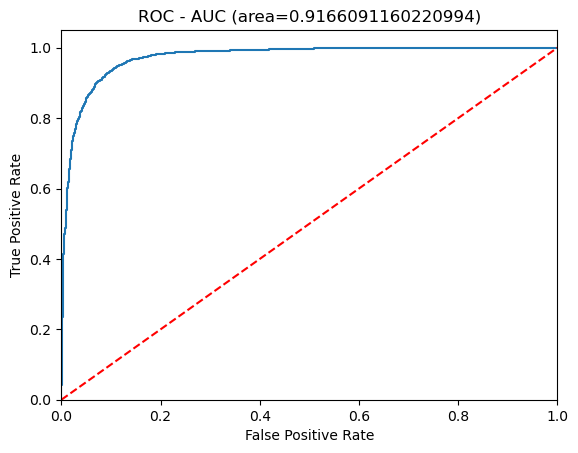


 <<< -------------------------------------------------- >>> 



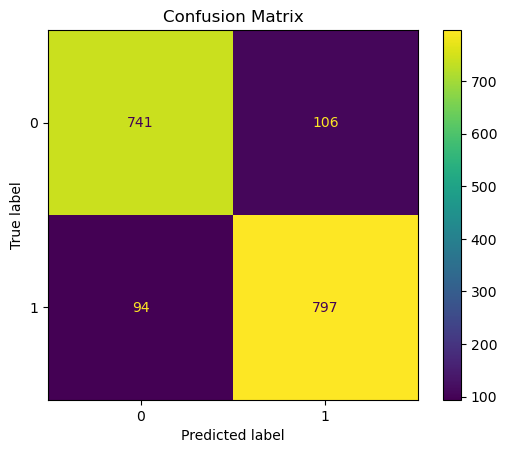

In [62]:
CAT = CatBoostClassifier(verbose=False)
# CAT = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=5, verbose=False)
evaluate(CAT)

In [63]:
# Save model
save_model(CAT, "CAT")

Model: CAT.pkl saved.


### LGBMClassifier

Training accuracy: 0.9541193882585101
Test accuracy: 0.8849252013808976
5-Fold Cross Validation Accuracy: 0.8636374176024381

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       847
           1       0.88      0.90      0.89       891

    accuracy                           0.88      1738
   macro avg       0.89      0.88      0.88      1738
weighted avg       0.89      0.88      0.88      1738


 <<< -------------------------------------------------- >>> 



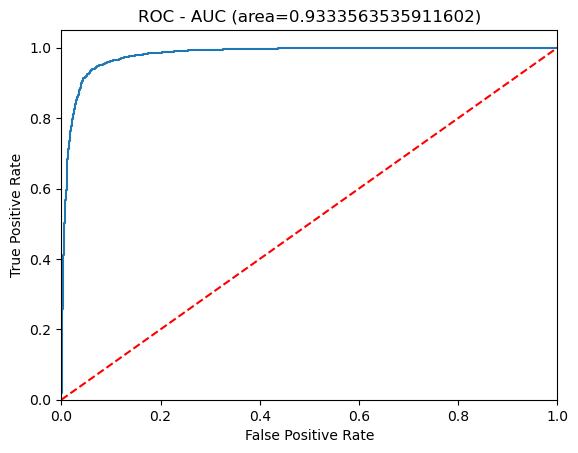


 <<< -------------------------------------------------- >>> 



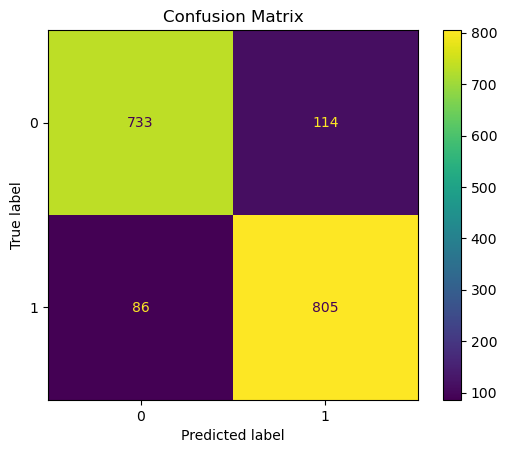

In [64]:
LGBM = LGBMClassifier(verbosity=-1)
evaluate(LGBM)

Fitting 5 folds for each of 162 candidates, totalling 810 fits

 <<< -------------------------------------------------- >>> 

Tuned model paramaters: {'learning_rate': 0.05, 'max_depth': 4, 'min_child_samples': 10, 'n_estimators': 500, 'subsample': 0.6}
Tuned model best score: 0.8815953479167618
Training accuracy: 0.9368524913665516
Test accuracy: 0.8791714614499425
5-Fold Cross Validation Accuracy: 0.8578836662360463

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       847
           1       0.87      0.89      0.88       891

    accuracy                           0.88      1738
   macro avg       0.88      0.88      0.88      1738
weighted avg       0.88      0.88      0.88      1738


 <<< -------------------------------------------------- >>> 



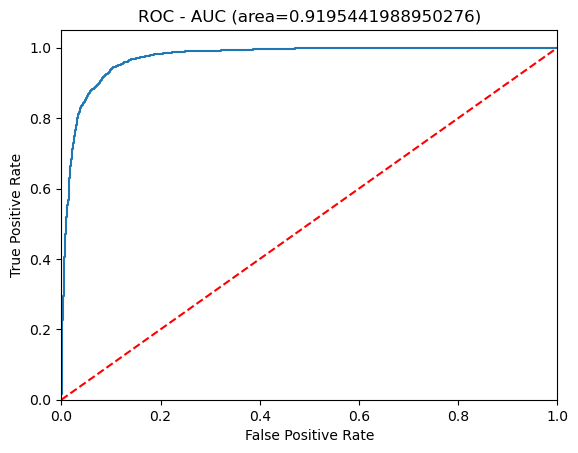


 <<< -------------------------------------------------- >>> 



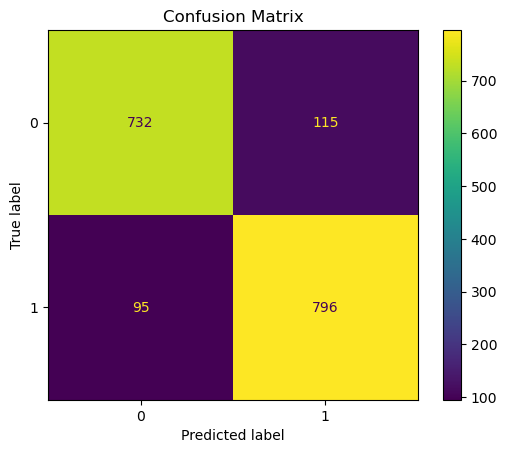

In [65]:
LGBM = LGBMClassifier(verbosity=-1)

param_grid = {"n_estimators":[100, 500], "subsample":[0.6,0.8,1.0], "max_depth":[3, 4, 5],
              "learning_rate":[0.1, 0.01, 0.05], "min_child_samples":[5, 10, 20]}

model_cv = GridSearchCV(LGBM, param_grid, cv=5, n_jobs=-1, verbose=1)
model_cv.fit(X_train, y_train)
barrier()
print(f"Tuned model paramaters: {model_cv.best_params_}")
print(f"Tuned model best score: {model_cv.best_score_}")
evaluate_no_fit(model_cv.best_estimator_)

Training accuracy: 0.9368524913665516
Test accuracy: 0.8791714614499425
5-Fold Cross Validation Accuracy: 0.8578836662360463

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       847
           1       0.87      0.89      0.88       891

    accuracy                           0.88      1738
   macro avg       0.88      0.88      0.88      1738
weighted avg       0.88      0.88      0.88      1738


 <<< -------------------------------------------------- >>> 



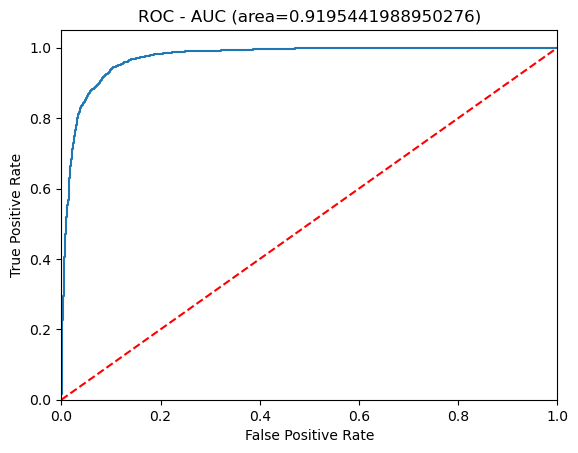


 <<< -------------------------------------------------- >>> 



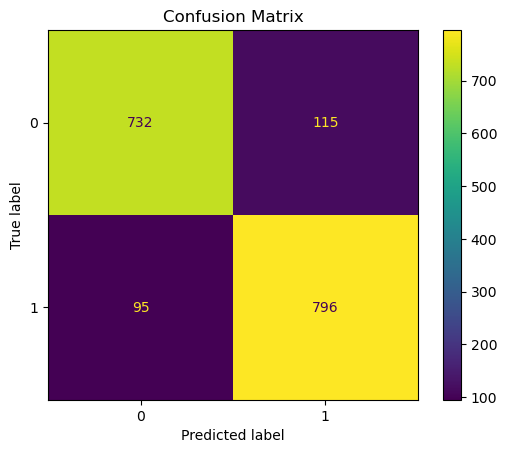

In [66]:
LGBM = LGBMClassifier(verbosity=-1).set_params(**model_cv.best_params_)
evaluate(LGBM)

In [67]:
# Save model
save_model(LGBM, "LGBM")

Model: LGBM.pkl saved.


### Final model collation

In [68]:
# Load saved models
DTC_feat_imp = load_model("DTC.pkl")
RF_feat_imp = load_model("RF.pkl")
XGB_feat_imp = load_model("XGB.pkl")
CAT_feat_imp = load_model("CAT.pkl")
LGBM_feat_imp = load_model("LGBM.pkl")

In [69]:
models = [DTC_feat_imp, RF_feat_imp, XGB_feat_imp, CAT_feat_imp, LGBM_feat_imp]

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print_bold(names + ":" )
    print(f"Test accuracy: {acc}")
    barrier()

DecisionTreeClassifier:
Test accuracy: 0.8354430379746836

 <<< -------------------------------------------------- >>> 

RandomForestClassifier:
Test accuracy: 0.8642117376294591

 <<< -------------------------------------------------- >>> 

XGBClassifier:
Test accuracy: 0.8584579976985041

 <<< -------------------------------------------------- >>> 

CatBoostClassifier:
Test accuracy: 0.8849252013808976

 <<< -------------------------------------------------- >>> 

LGBMClassifier:
Test accuracy: 0.8791714614499425

 <<< -------------------------------------------------- >>> 



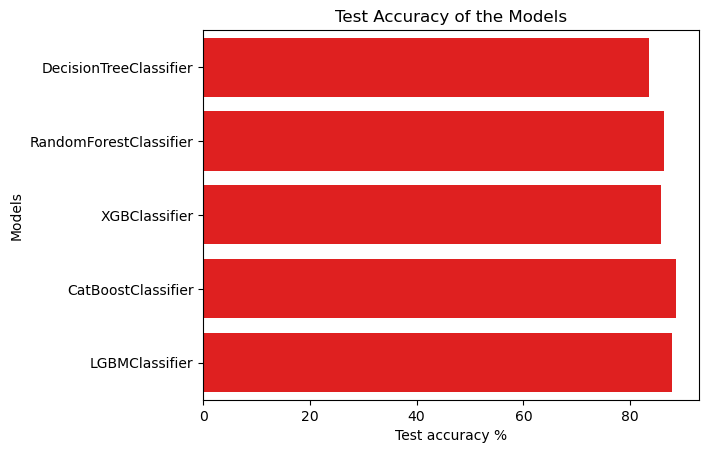

In [70]:
results = pd.DataFrame(columns=["Models", "Test accuracy"])
names = []
accs = []

for model in models:
    name = model.__class__.__name__
    names.append(name)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) 
    accs.append(acc)
    result = pd.DataFrame([[name, acc*100]], columns=["Models", "Test accuracy"])
    results = pd.concat([results, result])

sns.barplot(x="Test accuracy", y="Models", data=results, color="r")
plt.xlabel("Test accuracy %")
plt.title("Test Accuracy of the Models")
plt.show()

In [71]:
results.sort_values(by="Test accuracy", ascending=False, ignore_index=True)

,Models,Test accuracy
0,CatBoostClassifier,88.49
1,LGBMClassifier,87.92
2,RandomForestClassifier,86.42
3,XGBClassifier,85.85
4,DecisionTreeClassifier,83.54


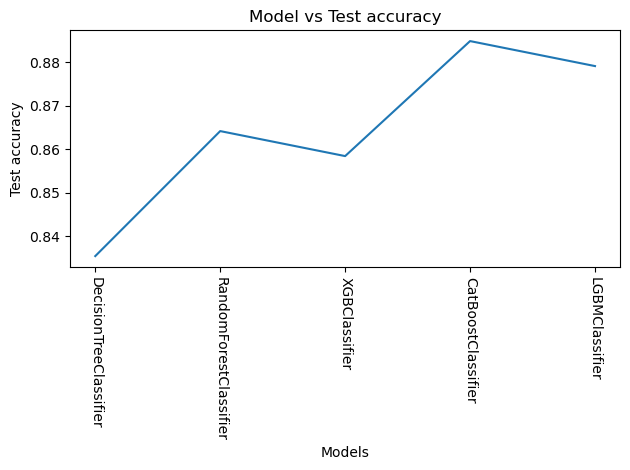

In [72]:
plt.plot(names, accs)
plt.xlabel("Models")
plt.ylabel("Test accuracy")
plt.title("Model vs Test accuracy")
plt.xticks(rotation=-90)
plt.tight_layout()
plt.show()

**NOTE:**
- All models have high and similar/comparable accuracies.

## Modeling dropped

#### Justification for dropped features
- At this junction, we have completed our modeling process using all features but, before moving on to **Feature Importance**, we can explore a different avenue with regards to feature selection.
- Firstly, it should be noted that the `duration` and `campaign` features are are deterministic in nature.
    - That is, while useful after collection, we can only know the length of the most recent call or the number of necessary calls after extensive and repetitive data collection.
    - Those features do not necessarily serve to give use demographical information about the customer segment(s) that would be willing or able to subscribe to a term deposit.
    - They are extrinsic in nature as opposed to the more intrinsic features such as a customer's `age`, `job`, `marital status`, `education level`, `debt level`, `bank balance`, `housing status`, and `loan status`.
    - Consequently, we will drop them and re-execute our initial analysis.
- Additionally, the `day`, `month` and `contact` features will be dropped for our secondary analysis as well.
    - The date of last contact may be immaterial if the business is not cyclical in nature and means of communication may be inconsequential as most people use cellphones regardless of demographic.
- We will perform our secondary analysis without these features **to see if the accuracy scores are comparable**.
    - Note that we fully expect the accuracy scores to reduce but if the decrease is not significant, it may provide some more intrinsic information about the customers or an avenue for further conversation with the client.

#### One hot encoding

In [73]:
df_enc_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5792 entries, 0 to 5791
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        5792 non-null   int64
 1   job        5792 non-null   int32
 2   marital    5792 non-null   int32
 3   education  5792 non-null   int32
 4   default    5792 non-null   int32
 5   balance    5792 non-null   int64
 6   housing    5792 non-null   int32
 7   loan       5792 non-null   int32
 8   contact    5792 non-null   int32
 9   day        5792 non-null   int64
 10  month      5792 non-null   int32
 11  duration   5792 non-null   int64
 12  campaign   5792 non-null   int64
 13  y          5792 non-null   int32
dtypes: int32(9), int64(5)
memory usage: 430.0 KB


In [74]:
print_uniques(df_enc_balanced)

age ------> [59 56 41 55 54 42 60 39 37 34 28 30 36 45 53 38 29 46 31 35 32 49 43 26
 40 33 24 23 48 52 57 51 44 50 27 47 25 58 61 62 68 75 22 69 64 66 85 72
 90 67 71 21 63 73 74 65 83 79 70 76 77 19 20 78 95]
job ------> [ 0  9  7  4  5 10  1  2  3  6  8]
marital ------> [1 2 0]
education ------> [1 2 0]
default ------> [0 1]
balance ------> [2343   45 1270 ...  537  -91 5149]
housing ------> [1 0]
loan ------> [0 1]
contact ------> [0 1]
day ------> [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31]
month ------> [ 8  6  5  1 10  9  2  4  3  7  0]
duration ------> [1042 1467 1389 ... 1026  977 1529]
campaign ------> [ 1  2  3  4  5  6 32  8 11  7  9 10 15 12 14 17 13 24 29 16 21 20 55 33
 27 18 36 19 25 22 51 35 28 26 30]
y ------> [1 0]


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [76]:
df_enc_balanced.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,59,0,1,1,0,2343,1,0,0,5,8,1042,1,1
1,56,0,1,1,0,45,0,0,0,5,8,1467,1,1
2,41,9,1,1,0,1270,1,0,0,5,8,1389,1,1
3,55,7,1,1,0,2476,1,0,0,5,8,579,1,1
4,54,0,1,2,0,184,0,0,0,5,8,673,2,1


In [77]:
# Drop the features as stated above
df_enc_balanced_dropped = df_enc_balanced.drop(["day", "month", "duration", "campaign", "contact"], axis=1)

In [78]:
# One-hot encoding the categorical variables with more than 1 category
df_enc_oh_dropped = pd.get_dummies(df_enc_balanced_dropped, columns=["job","marital","education"], drop_first=True)
df_enc_oh_dropped.head()

,age,default,balance,housing,loan,y,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,marital_1,marital_2,education_1,education_2
0,59,0,2343,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,56,0,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,41,0,1270,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,55,0,2476,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,54,0,184,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [79]:
df_enc_oh_dropped.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'y', 'job_1', 'job_2',
       'job_3', 'job_4', 'job_5', 'job_6', 'job_7', 'job_8', 'job_9', 'job_10',
       'marital_1', 'marital_2', 'education_1', 'education_2'],
      dtype='object')

**NOTE:**
- We dropped the first columns to prevent issues with multi-collinearity.

#### Train and test split

In [80]:
RANDOM_STATE = 42
X = df_enc_oh_dropped.drop("y", axis=1)
y = df_enc_oh_dropped["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
print_bold("X_train.shape, y_train.shape, X_test.shape, y_test.shape:")
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print_bold("y_train.sum(), y_test.sum(), y.sum():")
display(y_train.sum(), y_test.sum(), y.sum())

X_train.shape, y_train.shape, X_test.shape, y_test.shape:


(4054, 19)

(4054,)

(1738, 19)

(1738,)

y_train.sum(), y_test.sum(), y.sum():


2005

891

2896

#### Lazypredict

In [81]:
# Lazy preliminary assessment of multiple models
clf = LazyClassifier(verbose=-1, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:10<00:00,  2.84it/s]


[LightGBM] [Info] Number of positive: 2005, number of negative: 2049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 4054, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494573 -> initscore=-0.021708
[LightGBM] [Info] Start training from score -0.021708
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.58               0.58     0.58      0.58   
CalibratedClassifierCV             0.58               0.58     0.58      0.58   
AdaBoostClassifier                 0.58               0.58     0.58      0.58   
LogisticRegression                 0.58  

**NOTE:**
- Lazypredict provides an initial estimation of how different models may perform with the data.
- However, this assessment should be considered a rough guideline as it is made without model tuning.
- Thus, it will only serve informational purposes going forward.

#### Model evaluation functions

In [82]:
# Functions to evaluate models
# Draw roc-auc curve
def draw_roc(model):
    roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - AUC (area={roc_auc})")
    plt.show()

# Fit and evaluate model
def evaluate(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cross_val = cross_val_score(model, X_test, y_test, cv=5).mean()
    print_bold(f"Training accuracy: {model.score(X_train, y_train)}")
    print_bold(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
    print_bold(f"5-Fold Cross Validation Accuracy: {cross_val}")
    barrier()
    print_bold("Classification report:")
    print(classification_report(y_test, y_pred))
    cross = cross_val_score(model, X_test, y_test, cv=5).mean()
    barrier()
    draw_roc(model)
    barrier()
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate models without re-fitting
def evaluate_no_fit(model):
    y_pred = model.predict(X_test)
    cross_val = cross_val_score(model, X_test, y_test, cv=5).mean()
    print_bold(f"Training accuracy: {model.score(X_train, y_train)}")
    print_bold(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
    print_bold(f"5-Fold Cross Validation Accuracy: {cross_val}")
    barrier()
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    cross = cross_val_score(model, X_test, y_test, cv=5).mean()
    barrier()
    draw_roc(model)
    barrier()
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Confusion Matrix")
    plt.show()

# Assess and plot the standard devs of the cv scores for each fold and parameter set
def cv_std(cv):
    y = cv.cv_results_["std_test_score"]
    x = np.arange(1, y.shape[0] + 1)
    print(f"Mean of the standard deviations: {y.mean()}")
    print(f"Std of the standard deviations: {y.std()}")
    barrier()
    plt.plot(x, y)
    plt.title("Standard devs of CV scores")
    plt.xlabel("Param Candidates")
    plt.ylabel("Stds")
    plt.show()

### Logistic regression

Training accuracy: 0.5895411938825851
Test accuracy: 0.5811277330264673
5-Fold Cross Validation Accuracy: 0.5747755805094571

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       847
           1       0.59      0.57      0.58       891

    accuracy                           0.58      1738
   macro avg       0.58      0.58      0.58      1738
weighted avg       0.58      0.58      0.58      1738


 <<< -------------------------------------------------- >>> 



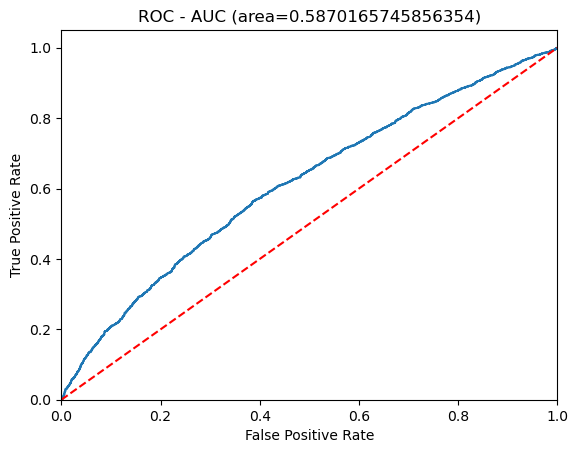


 <<< -------------------------------------------------- >>> 



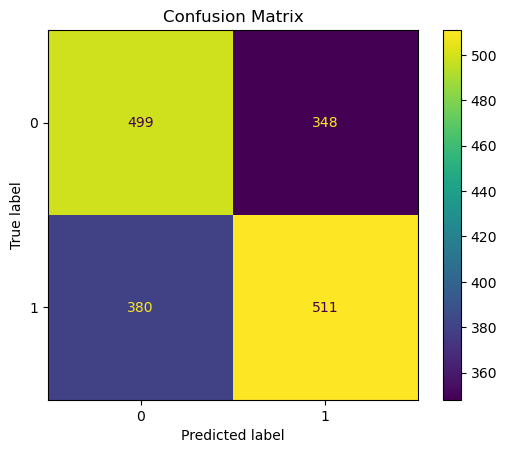

In [83]:
LR = LogisticRegression()
evaluate(LR)

### Gaussian naive bayes

Training accuracy: 0.5732609768130241
Test accuracy: 0.5581127733026467
5-Fold Cross Validation Accuracy: 0.5621335585809402

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       847
           1       0.59      0.44      0.51       891

    accuracy                           0.56      1738
   macro avg       0.56      0.56      0.55      1738
weighted avg       0.57      0.56      0.55      1738


 <<< -------------------------------------------------- >>> 



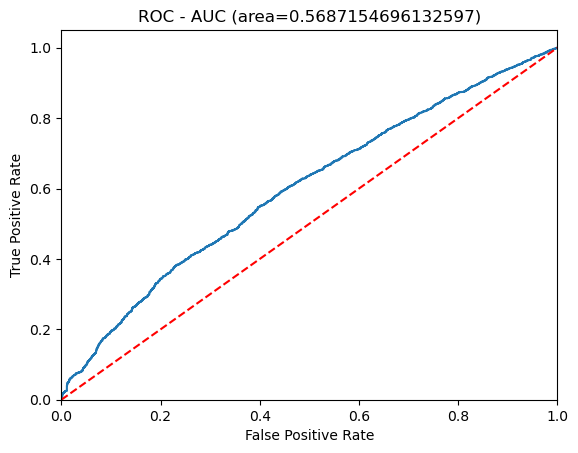


 <<< -------------------------------------------------- >>> 



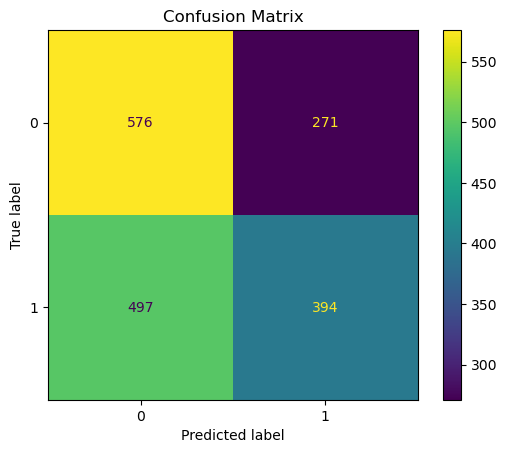

In [84]:
GNB = GaussianNB()
evaluate(GNB)

### K nearest neighbours

Training accuracy: 0.6988159842131229
Test accuracy: 0.5178365937859609
5-Fold Cross Validation Accuracy: 0.5138361654907417

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       847
           1       0.53      0.49      0.51       891

    accuracy                           0.52      1738
   macro avg       0.52      0.52      0.52      1738
weighted avg       0.52      0.52      0.52      1738


 <<< -------------------------------------------------- >>> 



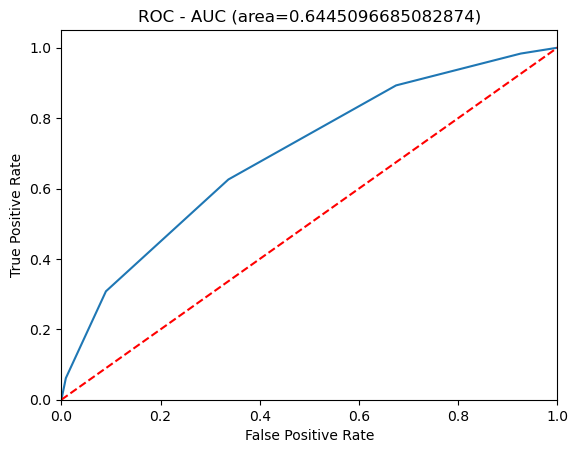


 <<< -------------------------------------------------- >>> 



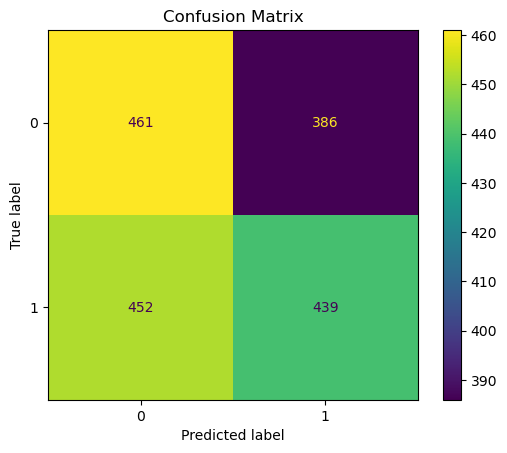

In [85]:
KNN = KNeighborsClassifier()
evaluate(KNN)

Fitting 5 folds for each of 14 candidates, totalling 70 fits

 <<< -------------------------------------------------- >>> 

Tuned model paramaters: {'n_neighbors': 4}
Tuned model best score: 0.5323118844286128
Training accuracy: 0.7160828811050814
Test accuracy: 0.5161104718066744
5-Fold Cross Validation Accuracy: 0.5236195302924906

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.70      0.59       847
           1       0.55      0.34      0.42       891

    accuracy                           0.52      1738
   macro avg       0.52      0.52      0.50      1738
weighted avg       0.52      0.52      0.50      1738


 <<< -------------------------------------------------- >>> 



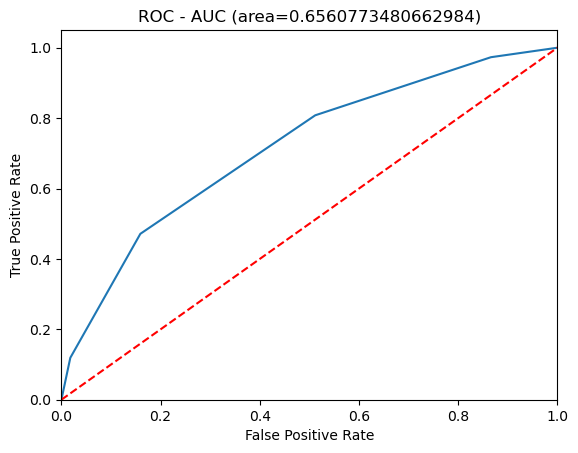


 <<< -------------------------------------------------- >>> 



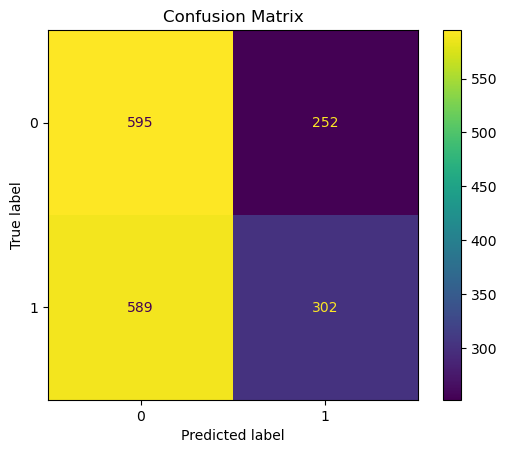

In [86]:
KNN = KNeighborsClassifier()

param_grid = {"n_neighbors": np.arange(1, 15)}

model_cv = GridSearchCV(KNN, param_grid, cv=5, n_jobs=-1, verbose=1)
model_cv.fit(X_train, y_train)
barrier()
print(f"Tuned model paramaters: {model_cv.best_params_}")
print(f"Tuned model best score: {model_cv.best_score_}")
evaluate_no_fit(model_cv.best_estimator_)

Training accuracy: 0.7160828811050814
Test accuracy: 0.5161104718066744
5-Fold Cross Validation Accuracy: 0.5236195302924906

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.70      0.59       847
           1       0.55      0.34      0.42       891

    accuracy                           0.52      1738
   macro avg       0.52      0.52      0.50      1738
weighted avg       0.52      0.52      0.50      1738


 <<< -------------------------------------------------- >>> 



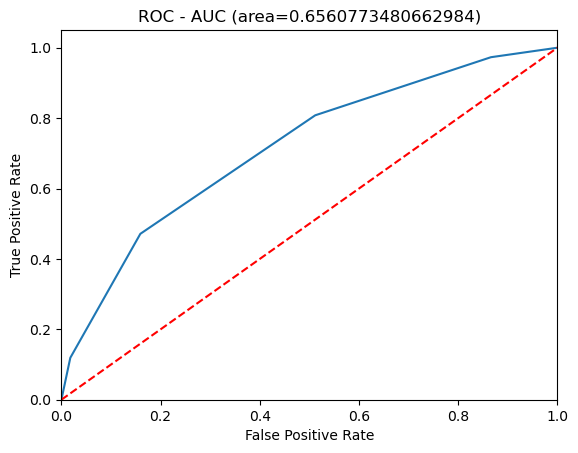


 <<< -------------------------------------------------- >>> 



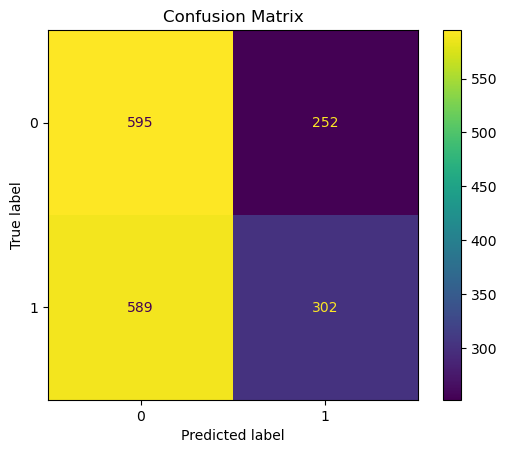

In [87]:
KNN = KNeighborsClassifier().set_params(**model_cv.best_params_)
evaluate(KNN)

### Decision tree

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 <<< -------------------------------------------------- >>> 

Tuned model paramaters: {'max_depth': 4, 'min_samples_split': 36}
Tuned model best score: 0.5806710203833098
Training accuracy: 0.6016280217069561
Test accuracy: 0.5638665132336018
5-Fold Cross Validation Accuracy: 0.5759531617476564

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.66      0.60       847
           1       0.59      0.47      0.53       891

    accuracy                           0.56      1738
   macro avg       0.57      0.57      0.56      1738
weighted avg       0.57      0.56      0.56      1738


 <<< -------------------------------------------------- >>> 



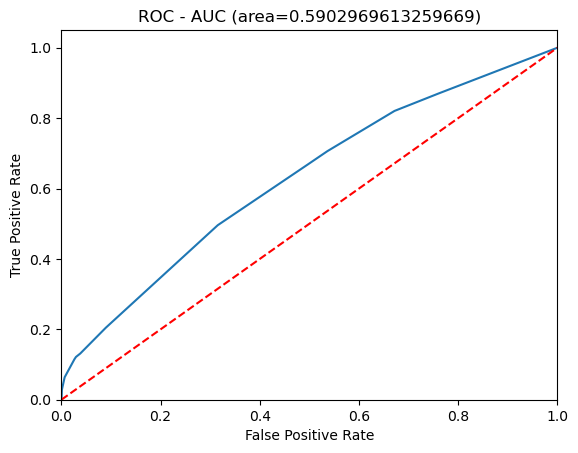


 <<< -------------------------------------------------- >>> 



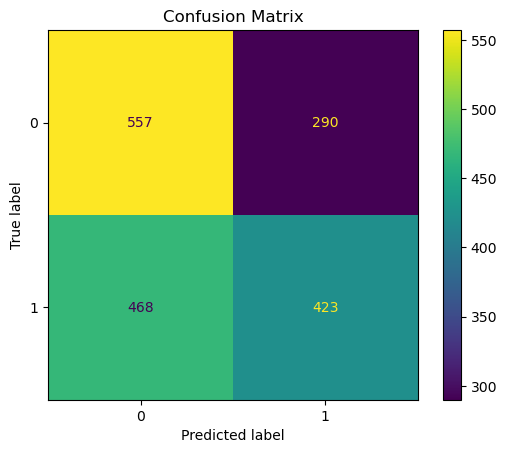

In [88]:
DTC = DecisionTreeClassifier()

param_grid = {"max_depth": range(1, 10), "min_samples_split": list(range(2, 50))}

model_cv = GridSearchCV(DTC, param_grid, cv=5, n_jobs=-1, verbose=1)
model_cv.fit(X_train, y_train)
barrier()
print(f"Tuned model paramaters: {model_cv.best_params_}")
print(f"Tuned model best score: {model_cv.best_score_}")
evaluate_no_fit(model_cv.best_estimator_)

Training accuracy: 0.6016280217069561
Test accuracy: 0.5638665132336018
5-Fold Cross Validation Accuracy: 0.5759531617476564

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.66      0.60       847
           1       0.59      0.47      0.53       891

    accuracy                           0.56      1738
   macro avg       0.57      0.57      0.56      1738
weighted avg       0.57      0.56      0.56      1738


 <<< -------------------------------------------------- >>> 



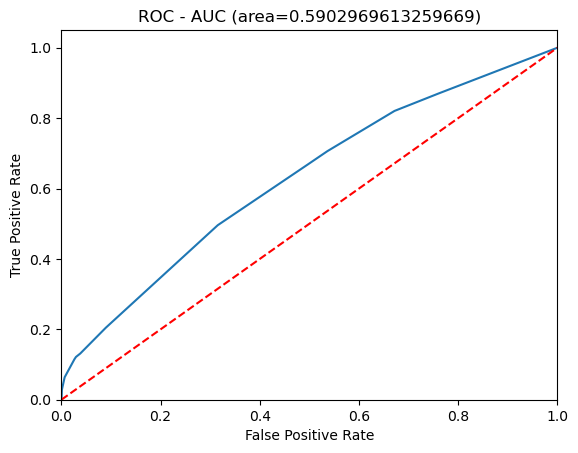


 <<< -------------------------------------------------- >>> 



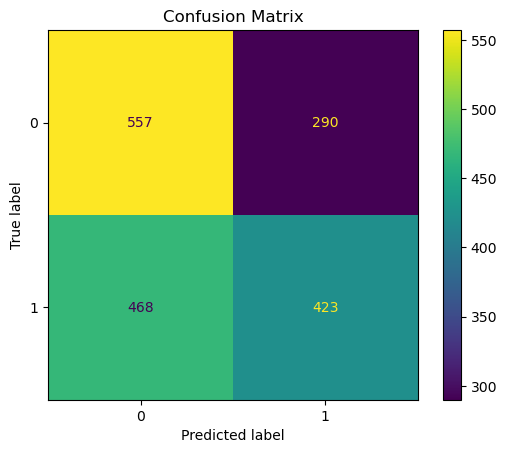

In [89]:
DTC = DecisionTreeClassifier().set_params(**model_cv.best_params_)
evaluate(DTC)

In [90]:
# Save model
save_model_dropped(DTC, "DTC")

Model: DTC.pkl saved.


### Random forest

Fitting 5 folds for each of 81 candidates, totalling 405 fits

 <<< -------------------------------------------------- >>> 

Tuned model paramaters: {'max_depth': 8, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 100}
Tuned model best score: 0.6036041466867607
Training accuracy: 0.6968426245683276
Test accuracy: 0.5903337169159953
5-Fold Cross Validation Accuracy: 0.5730795985292656

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.61       847
           1       0.62      0.52      0.56       891

    accuracy                           0.59      1738
   macro avg       0.59      0.59      0.59      1738
weighted avg       0.59      0.59      0.59      1738


 <<< -------------------------------------------------- >>> 



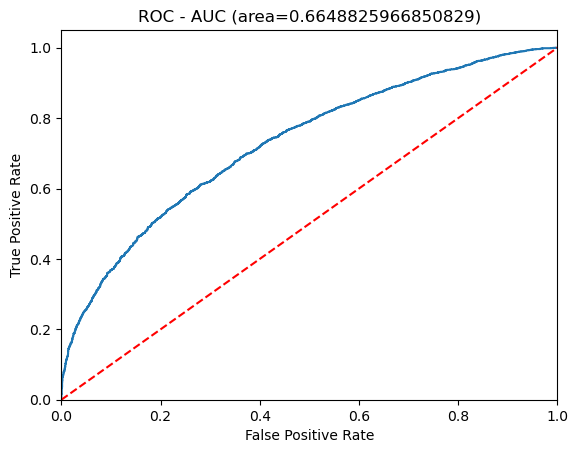


 <<< -------------------------------------------------- >>> 



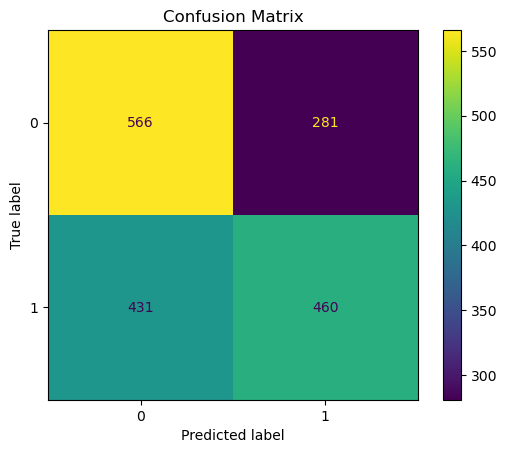

In [91]:
RF = RandomForestClassifier()

param_grid = {"max_depth":[2,5,8], "max_features":[2,5,8], "n_estimators":[10,50,100], "min_samples_split":[2,5,10]}

model_cv = GridSearchCV(RF, param_grid, cv=5, n_jobs=-1, verbose=1)
model_cv.fit(X_train, y_train)
barrier()
print(f"Tuned model paramaters: {model_cv.best_params_}")
print(f"Tuned model best score: {model_cv.best_score_}")
evaluate_no_fit(model_cv.best_estimator_)

Training accuracy: 0.7017760236803158
Test accuracy: 0.5886075949367089
5-Fold Cross Validation Accuracy: 0.5696015104839511

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       847
           1       0.62      0.53      0.57       891

    accuracy                           0.59      1738
   macro avg       0.59      0.59      0.59      1738
weighted avg       0.59      0.59      0.59      1738


 <<< -------------------------------------------------- >>> 



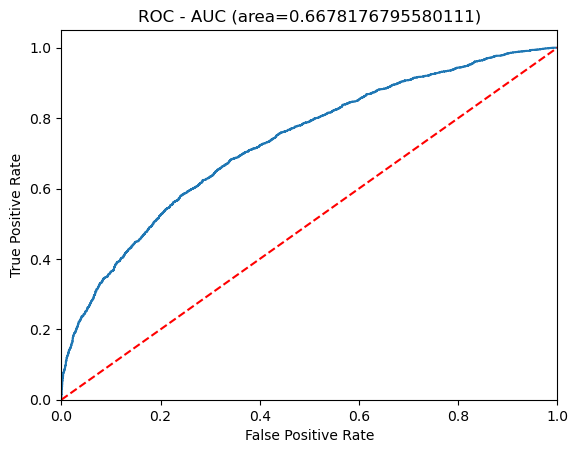


 <<< -------------------------------------------------- >>> 



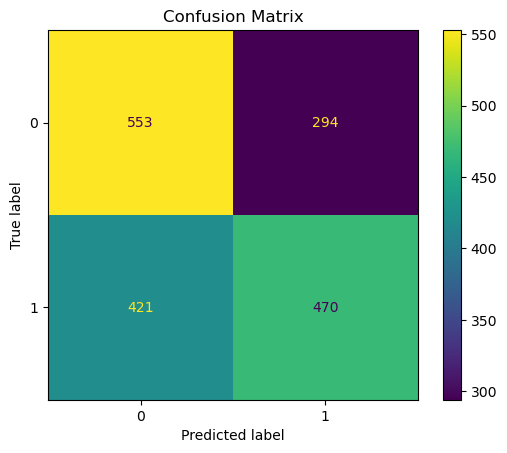

In [92]:
RF = RandomForestClassifier().set_params(**model_cv.best_params_)
evaluate(RF)

In [93]:
# Save model
save_model_dropped(RF, "RF")

Model: RF.pkl saved.


### XGBoost

Training accuracy: 0.6731623088307844
Test accuracy: 0.5891829689298044
5-Fold Cross Validation Accuracy: 0.5817019444168405

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       847
           1       0.62      0.50      0.56       891

    accuracy                           0.59      1738
   macro avg       0.59      0.59      0.59      1738
weighted avg       0.59      0.59      0.59      1738


 <<< -------------------------------------------------- >>> 



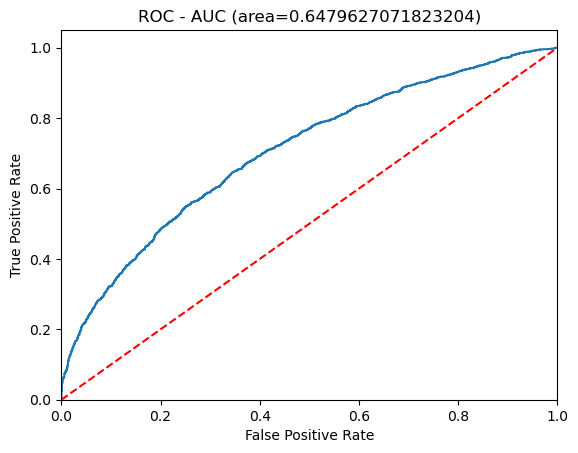


 <<< -------------------------------------------------- >>> 



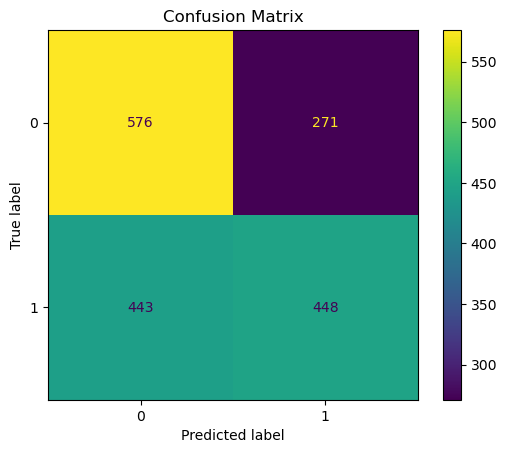

In [94]:
XGB = XGBClassifier(learning_rate=0.01, max_depth=6, min_samples_split=2, n_estimators=100, subsample=0.8)
evaluate(XGB)

In [95]:
# Save model
save_model_dropped(XGB, "XGB")

Model: XGB.pkl saved.


### CatBoost

Training accuracy: 0.7488899851998027
Test accuracy: 0.5684695051783659
5-Fold Cross Validation Accuracy: 0.560407764417503

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       847
           1       0.59      0.52      0.55       891

    accuracy                           0.57      1738
   macro avg       0.57      0.57      0.57      1738
weighted avg       0.57      0.57      0.57      1738


 <<< -------------------------------------------------- >>> 



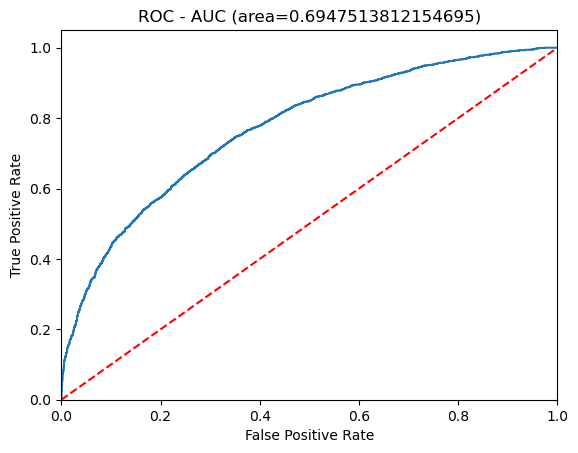


 <<< -------------------------------------------------- >>> 



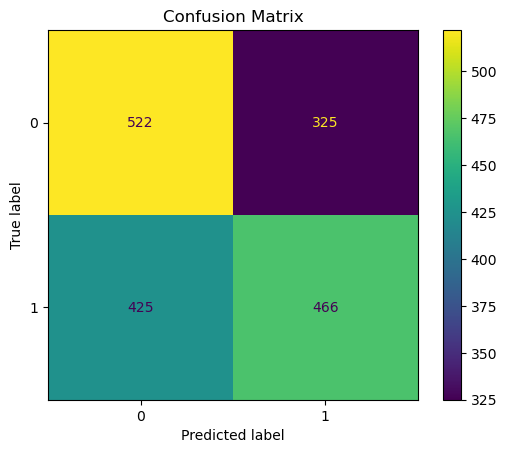

In [96]:
CAT = CatBoostClassifier(verbose=False)
# CAT = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=5, verbose=False)
evaluate(CAT)

In [97]:
# Save model
save_model_dropped(CAT, "CAT")

Model: CAT.pkl saved.


### LGBMClassifier

Training accuracy: 0.7863838184509127
Test accuracy: 0.570771001150748
5-Fold Cross Validation Accuracy: 0.5558166881976879

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.57       847
           1       0.59      0.55      0.57       891

    accuracy                           0.57      1738
   macro avg       0.57      0.57      0.57      1738
weighted avg       0.57      0.57      0.57      1738


 <<< -------------------------------------------------- >>> 



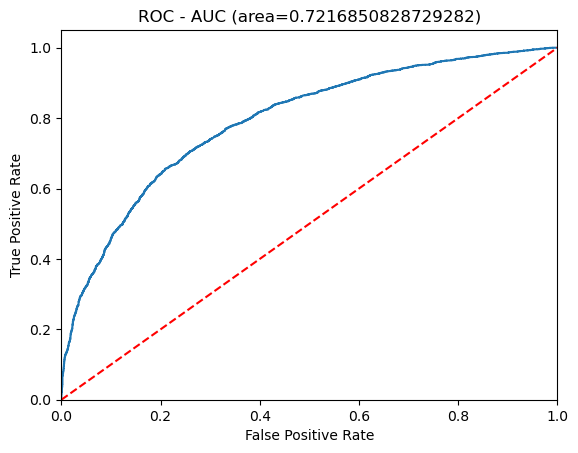


 <<< -------------------------------------------------- >>> 



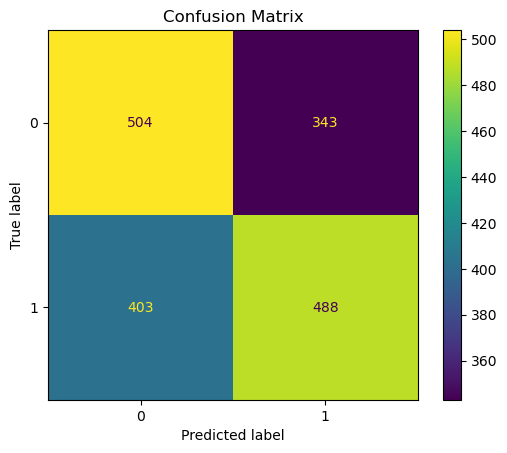

In [98]:
LGBM = LGBMClassifier(verbosity=-1)
evaluate(LGBM)

Fitting 5 folds for each of 162 candidates, totalling 810 fits

 <<< -------------------------------------------------- >>> 

Tuned model paramaters: {'learning_rate': 0.05, 'max_depth': 4, 'min_child_samples': 20, 'n_estimators': 100, 'subsample': 0.6}
Tuned model best score: 0.600892359683975
Training accuracy: 0.6536753823384311
Test accuracy: 0.5765247410817032
5-Fold Cross Validation Accuracy: 0.5713554605982312

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.59       847
           1       0.60      0.52      0.56       891

    accuracy                           0.58      1738
   macro avg       0.58      0.58      0.58      1738
weighted avg       0.58      0.58      0.58      1738


 <<< -------------------------------------------------- >>> 



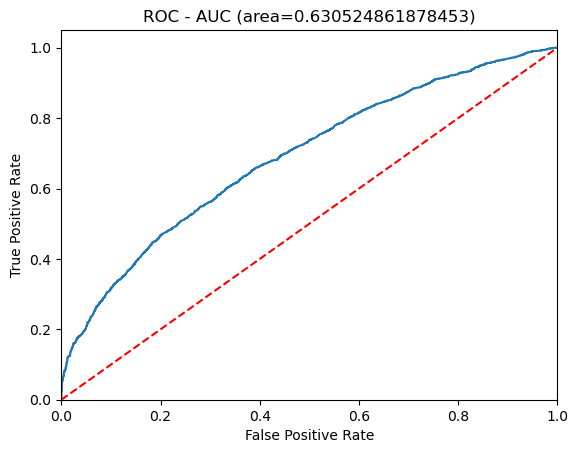


 <<< -------------------------------------------------- >>> 



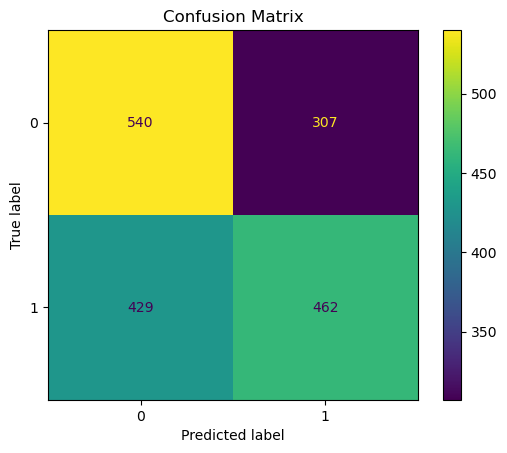

In [99]:
LGBM = LGBMClassifier(verbosity=-1)

param_grid = {"n_estimators":[100, 500], "subsample":[0.6,0.8,1.0], "max_depth":[3, 4, 5],
              "learning_rate":[0.1, 0.01, 0.05], "min_child_samples":[5, 10, 20]}

model_cv = GridSearchCV(LGBM, param_grid, cv=5, n_jobs=-1, verbose=1)
model_cv.fit(X_train, y_train)
barrier()
print(f"Tuned model paramaters: {model_cv.best_params_}")
print(f"Tuned model best score: {model_cv.best_score_}")
evaluate_no_fit(model_cv.best_estimator_)

Training accuracy: 0.6536753823384311
Test accuracy: 0.5765247410817032
5-Fold Cross Validation Accuracy: 0.5713554605982312

 <<< -------------------------------------------------- >>> 

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.59       847
           1       0.60      0.52      0.56       891

    accuracy                           0.58      1738
   macro avg       0.58      0.58      0.58      1738
weighted avg       0.58      0.58      0.58      1738


 <<< -------------------------------------------------- >>> 



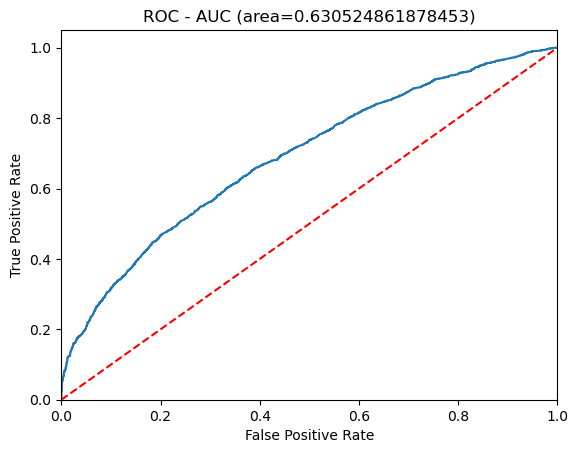


 <<< -------------------------------------------------- >>> 



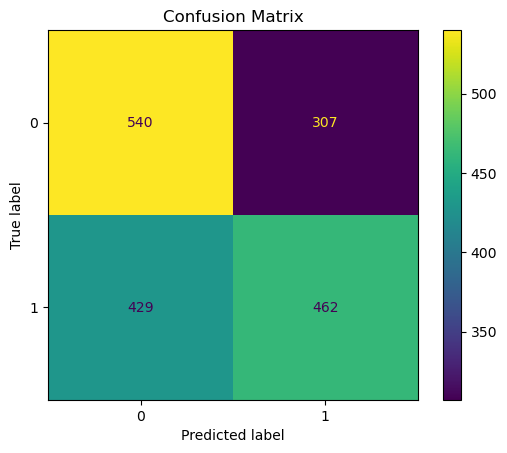

In [100]:
LGBM = LGBMClassifier(verbosity=-1).set_params(**model_cv.best_params_)
evaluate(LGBM)

In [101]:
# Save model
save_model_dropped(LGBM, "LGBM")

Model: LGBM.pkl saved.


### Final model collation

In [102]:
# Load saved models
DTC_feat_imp = load_model_dropped("DTC.pkl")
RF_feat_imp = load_model_dropped("RF.pkl")
XGB_feat_imp = load_model_dropped("XGB.pkl")
CAT_feat_imp = load_model_dropped("CAT.pkl")
LGBM_feat_imp = load_model_dropped("LGBM.pkl")

In [103]:
models = [DTC_feat_imp, RF_feat_imp, XGB_feat_imp, CAT_feat_imp, LGBM_feat_imp]

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print_bold(names + ":" )
    print(f"Test accuracy: {acc}")
    barrier()

DecisionTreeClassifier:
Test accuracy: 0.5638665132336018

 <<< -------------------------------------------------- >>> 

RandomForestClassifier:
Test accuracy: 0.5886075949367089

 <<< -------------------------------------------------- >>> 

XGBClassifier:
Test accuracy: 0.5891829689298044

 <<< -------------------------------------------------- >>> 

CatBoostClassifier:
Test accuracy: 0.5684695051783659

 <<< -------------------------------------------------- >>> 

LGBMClassifier:
Test accuracy: 0.5765247410817032

 <<< -------------------------------------------------- >>> 



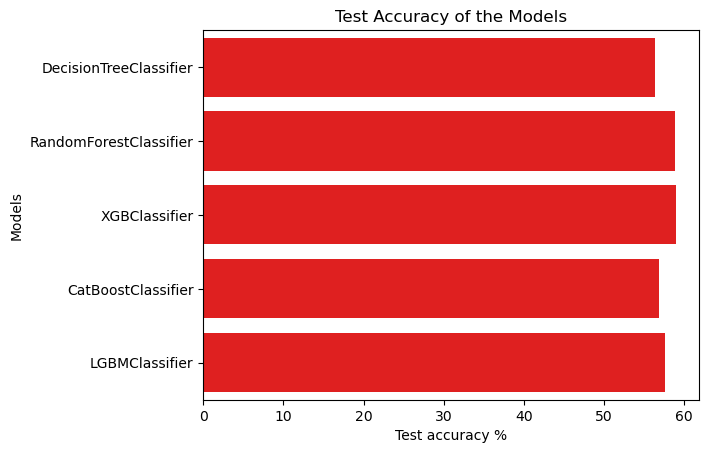

In [104]:
results = pd.DataFrame(columns=["Models", "Test accuracy"])
names = []
accs = []

for model in models:
    name = model.__class__.__name__
    names.append(name)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) 
    accs.append(acc)
    result = pd.DataFrame([[name, acc*100]], columns=["Models", "Test accuracy"])
    results = pd.concat([results, result])

sns.barplot(x="Test accuracy", y="Models", data=results, color="r")
plt.xlabel("Test accuracy %")
plt.title("Test Accuracy of the Models")
plt.show()

In [105]:
results.sort_values(by="Test accuracy", ascending=False, ignore_index=True)

,Models,Test accuracy
0,XGBClassifier,58.92
1,RandomForestClassifier,58.86
2,LGBMClassifier,57.65
3,CatBoostClassifier,56.85
4,DecisionTreeClassifier,56.39


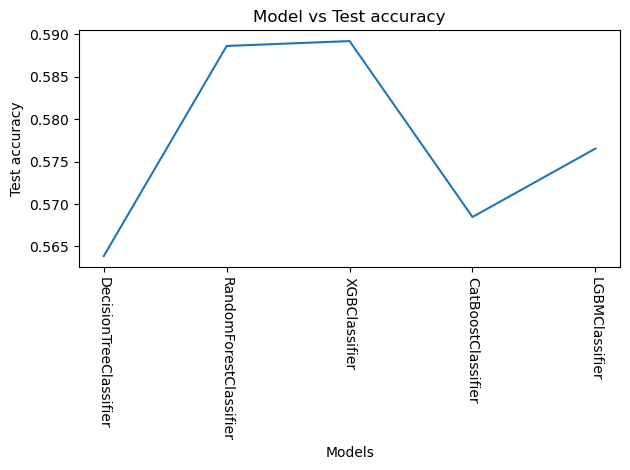

In [106]:
plt.plot(names, accs)
plt.xlabel("Models")
plt.ylabel("Test accuracy")
plt.title("Model vs Test accuracy")
plt.xticks(rotation=-90)
plt.tight_layout()
plt.show()

**NOTE:**
- All accuracies drop to just above 50% suggesting that they are slightly better than random guessing.
- For now, we will incorporate all features into our analysis and ignore this secondary analysis.

## Final conclusion & Inference

**Scope:**
- ACME is a company that provides machine learning solutions in the European banking market. They are interested in developing a machine learning system that can improve the success rate for calls made to customers for any product that their clients offer.

**Our goal:**
- Predict if the customer will subscribe (yes/no) to a term deposit (variable y).
- Hit 81% or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

**Data Wrangling:**
- The data was provided by the client and contained the following features: *age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, y/output*.

**Exploratory Data Analysis, Preprocessing and Training:**
- The data was *plotted* for visualization and *cleaned* of all missing values using *random imputation*.
- The data was *label encoded* and *one-hot encoded* for better modeling.
- The target feature was also balanced using random sampling so that both classes of output (yes or no) were equally represented.
- The data was split into training and test sets for evaluation and to evaluate any potential over-fitting.

**Modeling:**
- Multiple models were trained and evaluated using the training and test sets.
- Evaluation included the generation of *training accuracy, test accuracy, 5-fold cross validation accuracy, roc curve, roc-auc, precision, recall and f1-score*.
- CatBoostClassifier, LGBMClassifier, RandomForestClassifier, XGBClassifier and DecisionTreeClassifier all surpassed the goal of 81% test accuracy with `CatBoostClassifier` and `RandomForestClassifier` producing the best results of **~87%** test accuracy each.
- Secondary analysis using a sub-set of the data was shown to be almost no better than random guessing and will be ignored going forward.

**See notebook_2 for:**
- Feature importance
- Customer segmentation